**Data Science Tools 1 - Final Project**

Presented by:
- Gabor Horvath
- Brittany Laurent
- Don Smith

**Introduction:**

- Our dataset was drawn from a survey of ~730 people.
- Each row contains information regarding the respondent’s age, number of hours per day listening to music, favorite musical genre and streaming service, and the extent to which they experience mental health-related problems with Anxiety, Depression, OCD, and Insomnia.
- Respondents also indicated how often they listen to each of 16 listed musical genres.
- Our analytical interest was in attempting to predict respondents’ levels of self-reported mental health issues using information about their music-listening habits.
- We used the Google Colab suite of products to collaborate and design this notebook.

**Library Imports & Data Upload**

In [1]:
# Library imports
from google.colab import files
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from prettytable import PrettyTable

In [2]:
import sys
import os

########################
## This NEEDS to be run on first runtime connection for this notebook, as dtreeviz is not native to colab
########################
%config InlineBackend.figure_format = 'retina'
if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

import dtreeviz
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

In [3]:
# Load the csv file
uploaded_file = files.upload()  # Select file
# Convert the uploaded file's bytes to a file-like object for Pandas read
file_content = io.BytesIO(uploaded_file['music_data.csv'])
df_full = pd.read_csv(file_content)  # Read full csv as dataframe

Saving music_data.csv to music_data.csv


**Data Cleaning & Processing**
- Initial data cleaning steps included dropping unneeded columns and renaming others to adhere better to Python conventions.
- Some columns required data type conversion.
- Some distinct values in the single-answer ‘favorite genre’ column were merged based on an application of the “reasonable sufficient similarity” rule:
  - ‘Rap’ and ‘Hip-Hop’ became ‘Rap or Hip-Hop’
  - ‘Rock’ and ‘Metal’ became ‘Rock or Metal’
  - ‘Pop’ and ‘K-Pop’ became ‘Pop or K-Pop’
- The four mental health-related columns, each scored out of 10, were summed to create an ‘overall_mh’ column which could be used as a target variable.
- Internal correlations were run between the original and derived columns to ensure the conversion to a summed metric was defensible statistically.
- Some respondents’ reported values for ‘hours per day spent listening to music’ were assessed to be unrealistic and unlikely.
- Rather than lose data from an already-small dataset by removing those values, we substituted a “reasonable maximum” of 18 hours per day (24 total hrs - 8 sleeping hrs) for any original respondent-provided value over 18 hours.
- The Likert-type columns for each of the 16 genres (originally formed as “how often do you listen to this genre of music?”) were remapped as binary classifiers. Any response other than ‘Never’ was coded as 1, and all responses of ‘Never’ were coded as 0.


In [4]:
df = df_full.copy()  # Create copy
# Drop unneeded columns
df.drop(columns = ['Timestamp', 'BPM', 'Permissions'], inplace=True)

# Rename columns to match Python semantic requirements
df.rename(columns={
    'Age' : 'age',
    'Primary streaming service' : 'prim_stream',
    'Hours per day' : 'hours',
    'While working' : 'working',
    'Instrumentalist' : 'instrument',
    'Composer' : 'compose',
    'Fav genre' : 'fav_genre',
    'Exploratory' : 'explore',
    'Foreign languages' : 'for_lang',
    'Frequency [Classical]' : 'freq_class',
    'Frequency [Country]' : 'freq_country',
    'Frequency [EDM]' : 'freq_edm',
    'Frequency [Folk]' : 'freq_folk',
    'Frequency [Gospel]' : 'freq_gospel',
    'Frequency [Hip hop]' : 'freq_hiphop',
    'Frequency [Jazz]' : 'freq_jazz',
    'Frequency [K pop]' : 'freq_kpop',
    'Frequency [Latin]' : 'freq_latin',
    'Frequency [Lofi]' : 'freq_lofi',
    'Frequency [Metal]' : 'freq_metal',
    'Frequency [Pop]' : 'freq_pop',
    'Frequency [R&B]' : 'freq_rb',
    'Frequency [Rap]' : 'freq_rap',
    'Frequency [Rock]' : 'freq_rock',
    'Frequency [Video game music]' : 'freq_vidgame',
    'Anxiety' : 'anxiety',
    'Depression' : 'depression',
    'Insomnia' : 'insomnia',
    'OCD' : 'ocd',
    'Music effects' : 'mus_effects'}, inplace=True)

# Convert mental health columns to integer-type
# Build list of float columns for integer conversion
float_columns = ['anxiety', 'depression', 'insomnia', 'ocd']
df[float_columns] = df[float_columns].astype(int)  # Integer conversion

# Genre combination/merging
# Condition list
genre_conditions = [df['fav_genre'].isin(['Rap', 'Hip hop']),
                    df['fav_genre'].isin(['Rock', 'Metal']),
                    df['fav_genre'].isin(['Pop', 'K pop'])]

# New genre labels
merged_genres = ['Rap/Hip-hop', 'Rock/Metal', 'Pop/K-pop']

# Apply conditions and new labels
df['fav_genre'] = np.select(genre_conditions, merged_genres, default=df['fav_genre'])

# Build a new 'musician' feature by combining 'instrument' and 'composer' columns
# Direct conversions to binary
df['instrument'] = (df['instrument'] == 'Yes').astype(int)
df['compose'] = (df['compose'] == 'Yes').astype(int)

# Conditional column creation
df['musician'] = (df['instrument'] | df['compose']).astype(int)

# Create new 'overall_mh' column as the sum of the four mental health columns
# List of mental health (mh) column names
mh_cols = ['anxiety', 'depression', 'insomnia', 'ocd']

# Sum values across specified columns
df['overall_mh'] = df[mh_cols].sum(axis=1)

# Median replacement for missing values in 'age' column
df['age'] = df['age'].fillna(df['age'].median())

# Set all values for 'hours' greater than 18.0 to 18.0 - a 'reasonable max'
df.loc[df['hours'] > 18.0, 'hours'] = 18.0
df['hours'] = df['hours'].round(1)  # Set common decimal precision for all rows

# Mutate all genre frequency columns into binary classifiers
# Responses of 'Never' -> 0, else 1
# List of genre frequency columns
freq_cols = [
    'freq_class',
    'freq_country',
    'freq_edm',
    'freq_folk',
    'freq_gospel',
    'freq_hiphop',
    'freq_jazz',
    'freq_kpop',
    'freq_latin',
    'freq_lofi',
    'freq_metal',
    'freq_pop',
    'freq_rb',
    'freq_rap',
    'freq_rock',
    'freq_vidgame'
]

# Lambda function to apply binary mapping to relevant columns
df[freq_cols] = df[freq_cols].apply(lambda x: np.where(x == 'Never', 0, 1))

# Mutate 'working,' 'explore,' and 'for_lang' columns into binary classifiers
# List of relevant columns
verbose_bool_cols = ['working', 'explore', 'for_lang']

# Apply binary mapping
df[verbose_bool_cols] = df[verbose_bool_cols].apply(lambda x: np.where(x == 'No', 0, 1))

# Revising values in 'prim_stream' and handling missing values
# Reset missing values to string of 'none'
df['prim_stream'] = df['prim_stream'].fillna('none')

# Create a mapping dictionary for new values
stream_value_mapping = {
    'Spotify': 'spotify',
    'Pandora': 'pandora',
    'YouTube Music': 'youtube',
    'Apple Music': 'apple',
    'Other streaming service': 'other',
    'I do not use a streaming service.': 'none',
    'none': 'none'  # Ensure NaN values converted to 'none' are correctly mapped
}

# Apply mapping
df['prim_stream'] = df['prim_stream'].map(stream_value_mapping)

# Mutate 'mus_effects' column into a binary classifier where 'Improve' -> 1, else 0
df['mus_effects'] = df['mus_effects'].apply(lambda x: np.where(x == 'Improve', 1, 0))

df  # Visual check of processed data

age prim_stream  hours  working  instrument  compose         fav_genre  \
0    18.0     spotify    3.0        1           1        1             Latin   
1    63.0     pandora    1.5        1           0        0        Rock/Metal   
2    18.0     spotify    4.0        0           0        0  Video game music   
3    61.0     youtube    2.5        1           0        1              Jazz   
4    18.0     spotify    4.0        1           0        0               R&B   
..    ...         ...    ...      ...         ...      ...               ...   
731  17.0     spotify    2.0        1           1        0        Rock/Metal   
732  18.0     spotify    1.0        1           1        0         Pop/K-pop   
733  19.0       other    6.0        1           0        1       Rap/Hip-hop   
734  19.0     spotify    5.0        1           1        0         Classical   
735  29.0     youtube    2.0        1           0        0       Rap/Hip-hop   

     explore  for_lang  freq_class  ...  freq_rap  freq_rock  freq_vidgame  \
0          1         1           1  ...         1          0             1   
1          1         0           1  ...         1          1             1   
2          0         1           0  ...         1          1             1   
3          1         1           1  ...         0          0             0   
4          1         0           0  ...         1          0             1   
..       ...       ...         ...  ...       ...        ...           ...   
731        1         1           1  ...         1          1             0   
732        1         1           1  ...         0          1             1   
733        1         0           1  ...         1          1             1   
734        0         0           1  ...         0          0             1   
735        1         1           1  ...         1          1             1   

     anxiety  depression  insomnia  ocd  mus_effects  musician  overall_mh  
0          3           0         1    0            0         1           4  
1          7           2         2    1            0         0          12  
2          7           7        10    2            0         0          26  
3          9           7         3    3            1         1          22  
4          7           2         5    9            1         0          23  
..       ...         ...       ...  ...          ...       ...         ...  
731        7           6         0    9            1         1          22  
732        3           2         2    5            1         1          12  
733        2           2         2    2            1         1           8  
734        2           3         2    1            1         1           8  
735        2           2         2    5            1         0          11  

[736 rows x 32 columns]

In [5]:
# Confirm that no null values remain
null_counts = df.isnull().sum()  # Column-level count of null values
columns_with_nulls = null_counts[null_counts > 0]  # Columns with null count > 0
columns_with_nulls  # Table of columns with null values is an empty series

Series([], dtype: int64)

*The result of the above is an empty list. Our data cleaning and processing are complete.*

**'Sanity Check:'**

Ensuring that our original four mental health-related columns are all well-correlated with the aggregated 'overall_mh' tagret feature.

In [6]:
# Correlation checks
# Ensure that individual mh columns are all highly correlated with new aggregated column
mh_corr = df[mh_cols + ['overall_mh']].corr()['overall_mh'].drop('overall_mh')
print(mh_corr)
# Correlations are sufficiently high to use our aggregated column as our target
# It's clear at this point that before we can build a rigorous cluster model or analyze mental health in the context of musical habits, we have to drop the individual mh features
# They are going to be far too important/impactful in terms of their association with overall_mh
df.drop(columns=mh_cols, inplace=True)

anxiety       0.756761
depression    0.750830
insomnia      0.688768
ocd           0.617376
Name: overall_mh, dtype: float64


CORRELATIONS: Target Variable - 'overall_mh'
freq_metal      0.175332
hours           0.164089
freq_rap        0.151574
freq_edm        0.138610
freq_hiphop     0.116449
freq_folk       0.113125
freq_lofi       0.085862
freq_vidgame    0.079718
working         0.076737
mus_effects     0.075407
freq_rock       0.070678
for_lang        0.066090
freq_rb         0.065392
explore         0.060411
compose         0.059503
freq_pop        0.058483
freq_kpop       0.030933
musician        0.026133
instrument      0.025649
freq_country    0.025335
freq_gospel     0.016204
freq_class      0.007396
freq_latin      0.006519
freq_jazz       0.000144
age            -0.146046
Name: overall_mh, dtype: float64


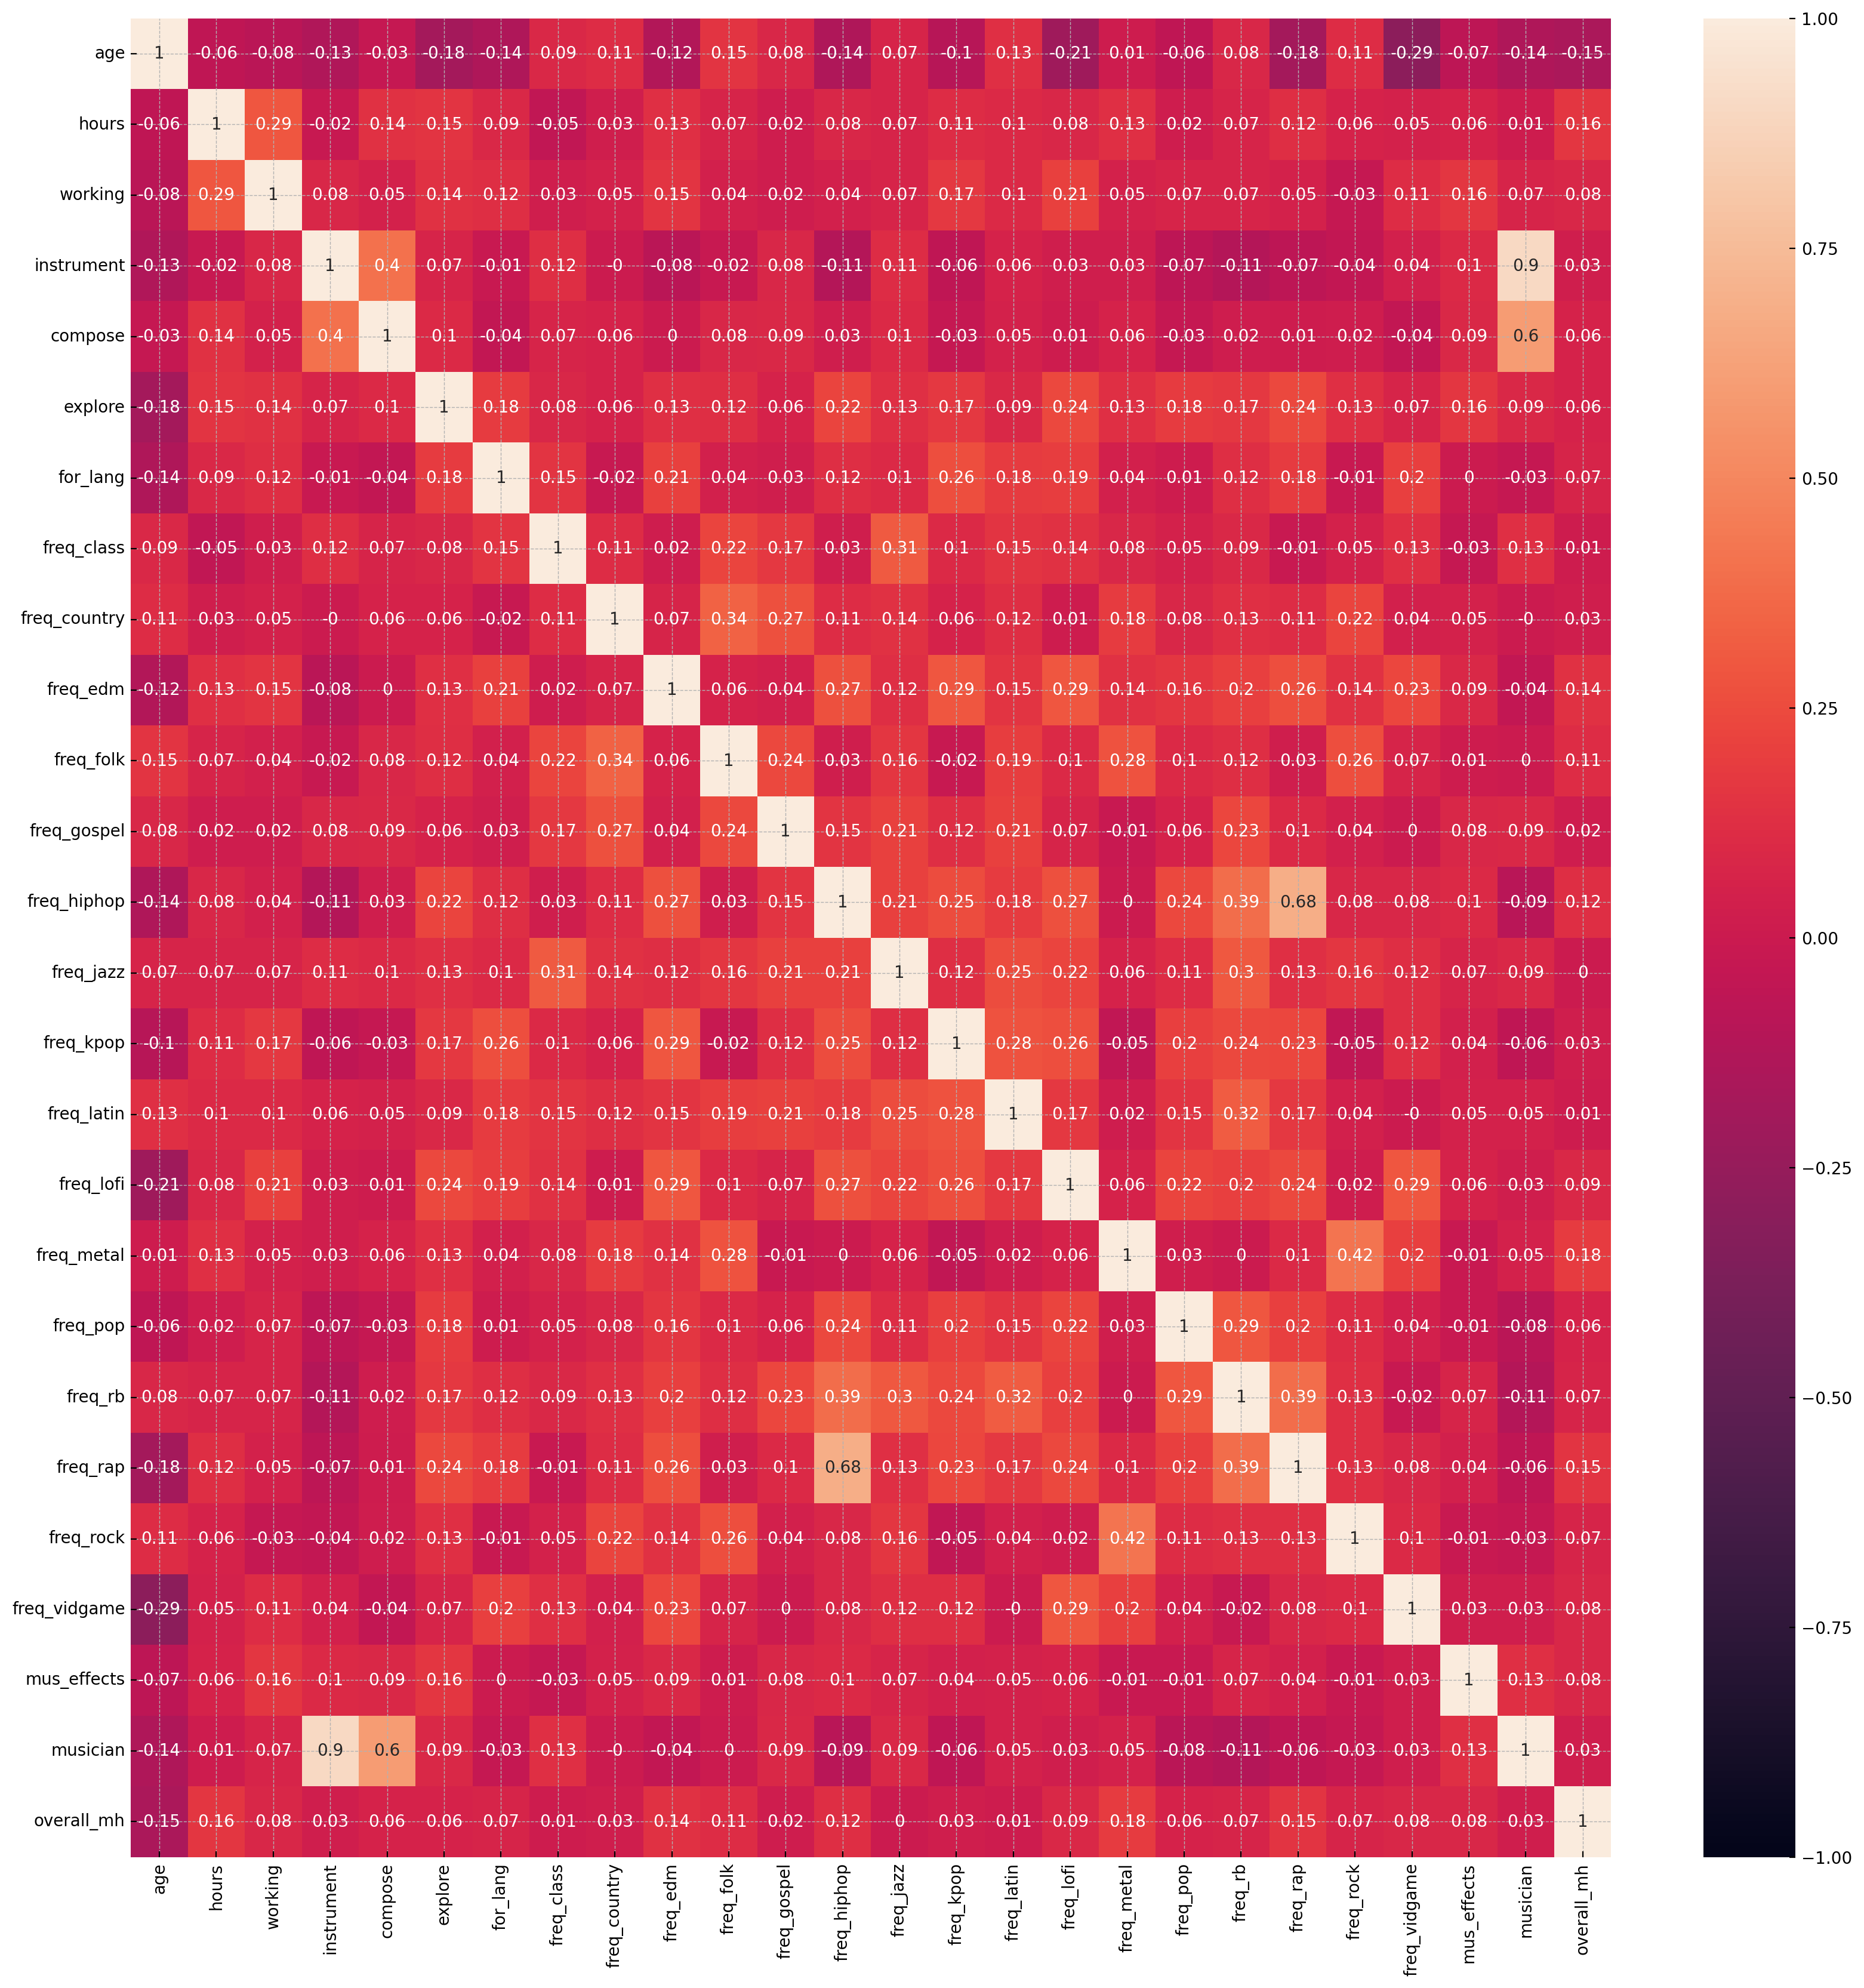

In [7]:
# Check other numerical correlations with target
numerical_df = df.select_dtypes(include=['number'])  # Filter for numerical columns
corr_matrix = numerical_df.corr()  # Compute correlation matrix
# Extract and sort correlation values with the target, exclude target
target_correlations = corr_matrix['overall_mh'].sort_values(ascending=False).drop('overall_mh')
print("CORRELATIONS: Target Variable - 'overall_mh'")
print(target_correlations)  # Note that Pearson coeffs are scale-invariant - can leave binary classifiers intact

with plt.style.context('bmh'):  # Matplotlib's context management allows for easy access to effective, consistent visual language
  # Calling SNS heatmap - 'bmh' is our style of choice for this project, as it provides clear spacing of data from axes and unobstrusive, helpful gridlines
  fig = plt.figure(figsize= (20, 20))
  # Set vmin and vmax explicitly
  sns.heatmap(corr_matrix.round(2), annot=True, vmin=-1, vmax=1)
  plt.savefig('music_mh_heatmap.png')  # Ensure we have files to hand out
  plt.show()

**First Analytical Steps:**
- Because our initial correlation values (both against our target value and among the features) produced no obvious guidance for how to proceed, we began with an unsupervised machine-learning method: K-Means cluster analysis.
- Our hope was that clustering the data would show us where the meaningful variance/differentiation among respondents could be found and that we could use those results to better guide our regressor-based predictions of overall mental health.
- The data were prepared appropriately with scaling and one-hot encoding. The next task was to identify the correct number of clusters using inertia values and silhouette scores.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10

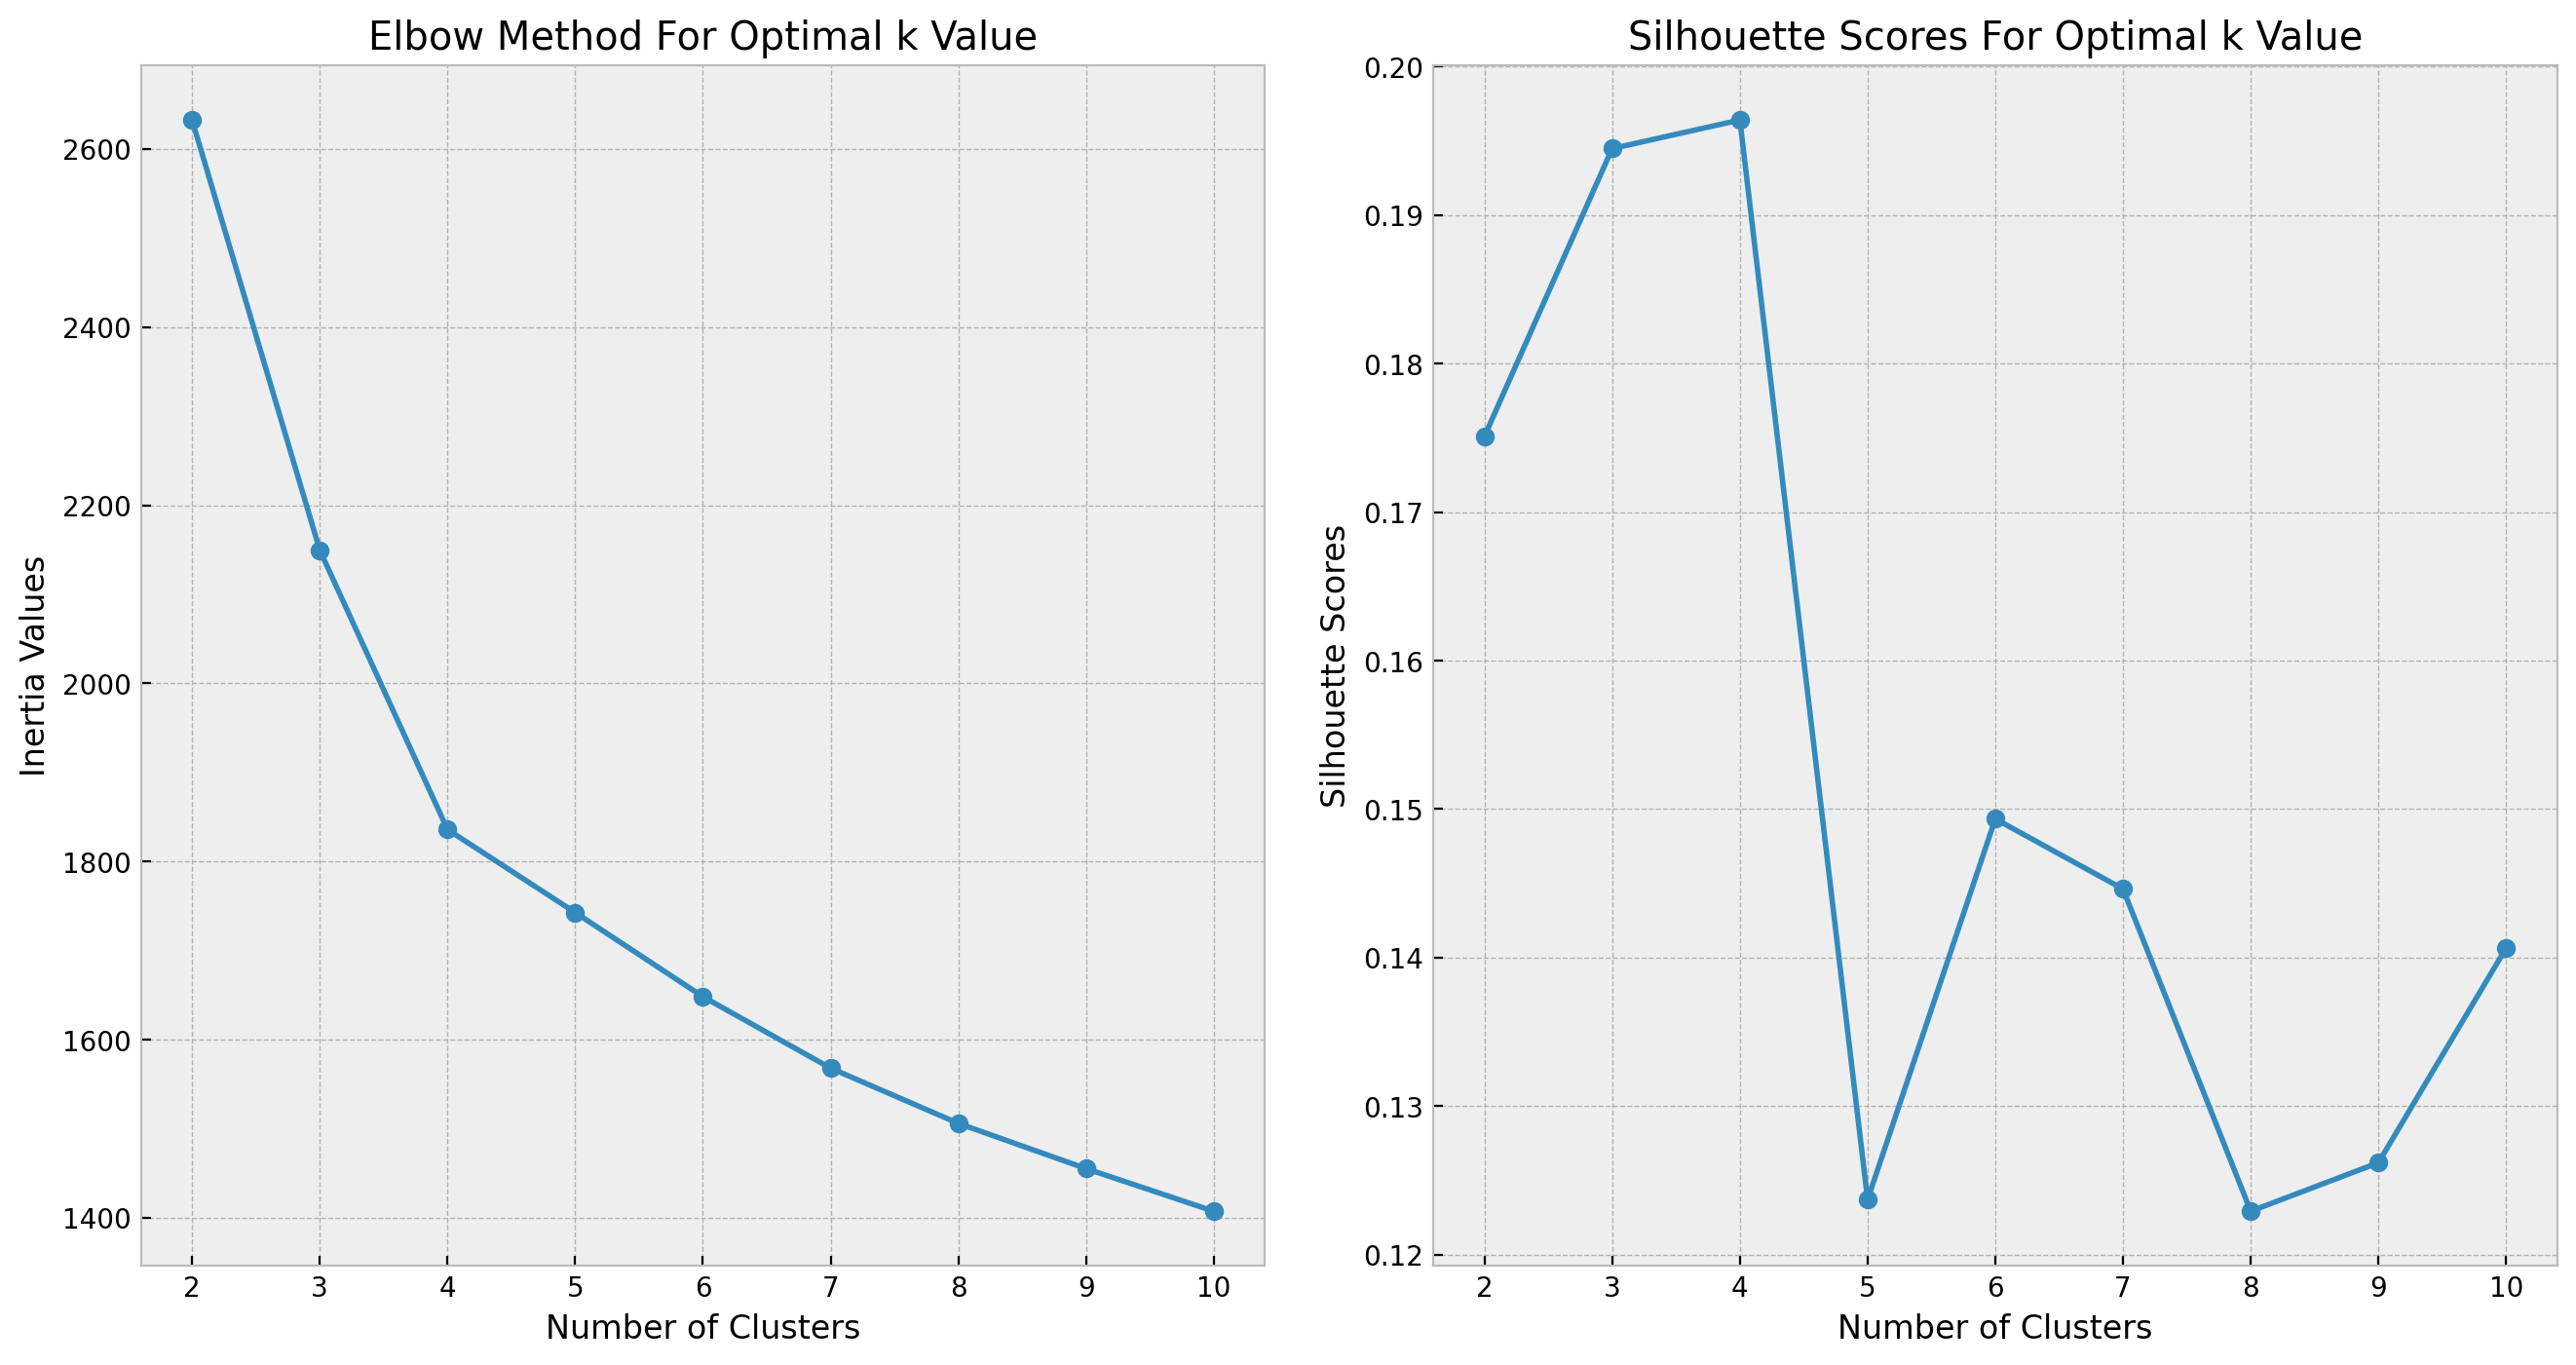

In [8]:
# Unsupervised Machine Learning
# A k-means cluster analysis will group respondents based on their similarity across multiple features.
# This will help us to identify natural groupings within the respondents and approach our mental health analysis more deliberately.
# The cluster analysis involves several steps: data scaling, one-hot encoding, choice of cluster number, centroid analysis, and feature importance analysis

# Step 1: Data Preparation
# Define columns requiring transformation
num_cols = ['age', 'hours', 'overall_mh']
cat_cols = ['prim_stream', 'fav_genre']
# NOTE: All binary classifier columns may be left intact for k-means

# Create transformers
num_transform = Pipeline(steps=[('scaler', StandardScaler())])
cat_transform = Pipeline(steps=[('onehot', OneHotEncoder())])

# Combine transformers and create complete column preprocessor
preprocessor = ColumnTransformer(transformers=[('num', num_transform, num_cols), ('cat', cat_transform, cat_cols)])
# NOTE: Binary classifier columns are not included - they don't require transformation

# Call preprocessor and create cluster-ready data
cluster_data = preprocessor.fit_transform(df)

# Step 2: Select the correct number of clusters by calling and comparing the elbow and silhouette score methods
cluster_range = range(2, 11)  # Evaluate possible cluster range from 2 to 10 clusters

# Initialize empty lists for inertia values and silhouette scores
inertia_vals = []
sil_scores = []

for n_clusters in cluster_range:  # For each potential cluster value in the cluster range
    kmeans = KMeans(n_clusters=n_clusters, random_state=4)  # Fix random state
    cluster_labels = kmeans.fit_predict(cluster_data)  # Fit the kmeans algorithm

    inertia_vals.append(kmeans.inertia_)  # Append the inertia value

    sil_avg = silhouette_score(cluster_data, cluster_labels)  # Compute the silhouette score
    sil_scores.append(sil_avg)  # Append the silhouette score

with plt.style.context('bmh'):
  # Use 'plt.subplots' for simple side-by-side viz. 'gridspec_kw' reduces space between viz here
  clusterfig, ax = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'wspace':0.15})
  # Simple lineplots will do for these data
  # Plot to apply the elbow method
  ax[0].plot(cluster_range, inertia_vals, marker='o')
  ax[0].set_title('Elbow Method For Optimal k Value')
  ax[0].set_xlabel('Number of Clusters')
  ax[0].set_ylabel('Inertia Values')

  # Plot to assess silhouette scores
  ax[1].plot(cluster_range, sil_scores, marker='o')
  ax[1].set_title('Silhouette Scores For Optimal k Value')
  ax[1].set_xlabel('Number of Clusters')
  ax[1].set_ylabel('Silhouette Scores')

  plt.savefig('music_mh_clusters1.png')


# Both the elbow method and silhouette score plot indicate that the correct number of clusters is 4.

# Performing cluster analysis with four clusters

# Create pipeline
# Note: Based on above plots, the correct number of clusters is 4
pipeline = Pipeline([ ('preprocessor', preprocessor), ('cluster', KMeans(n_clusters=4, random_state=4)) ])

pipeline.fit(df)  # Fit the cluster model with 4 clusters

cluster_labels = pipeline.predict(df)  # Predicting cluster labels for the original data

df['cluster_label'] = cluster_labels  # Add the cluster labels to the DataFrame

**ANOVA Tests:**
- After the clustering was performed and cluster labels were applied to each row, we ran per-feature One-Way ANOVA tests to identify which features were most important in cluster differentiation.
- A higher F-Statistic suggests a larger difference between the group means, implying that the feature is more significant in differentiating between the clusters.

In [9]:
# We can analyze feature importance in terms of cluster differentiation by applying one-way ANOVA tests
anova_columns = [col for col in df.columns if col not in cat_cols and col != 'cluster_label']
anova_outcomes = []  # Initialize an empty list to store ANOVA results

# Perform one-way ANOVA for each numerical feature
for feature in anova_columns:
    # Define the groups (i.e. clusters) for the ANOVA tests
    groups = [df[df['cluster_label'] == cluster][feature] for cluster in df['cluster_label'].unique()]

    result = f_oneway(*groups)  # Perform ANOVA tests

    anova_outcomes.append({'Feature': feature, 'F-Statistic': result.statistic, 'P-Value': result.pvalue})  # Append the results

anova_df = pd.DataFrame(anova_outcomes)  # Convert results to a dataframe
anova_df_sorted = anova_df.sort_values(by='F-Statistic', ascending=False)  # Sort results by F statistic

anova_df_sorted

# This is powerful initial evidence that in terms of cluster differentiation, the age, overall_mh, and hours features are FAR more important than the all others

Feature  F-Statistic        P-Value
0            age   536.518860  2.666007e-184
25    overall_mh   353.449424  7.577358e-142
1          hours   320.939829  5.809962e-133
22  freq_vidgame    19.432189   3.941803e-12
9       freq_edm    10.652672   7.344902e-07
20      freq_rap    10.533888   8.668695e-07
16     freq_lofi     8.801150   9.741571e-06
6       for_lang     7.749029   4.234468e-05
17    freq_metal     6.613691   2.063785e-04
5        explore     6.114775   4.133986e-04
12   freq_hiphop     5.359158   1.180799e-03
19       freq_rb     4.924432   2.155512e-03
10     freq_folk     4.693881   2.963693e-03
2        working     4.501490   3.863849e-03
18      freq_pop     3.562331   1.398810e-02
21     freq_rock     3.511337   1.499286e-02
3     instrument     3.446398   1.637611e-02
24      musician     2.811063   3.859093e-02
15    freq_latin     2.522183   5.672052e-02
7     freq_class     2.391270   6.745423e-02
11   freq_gospel     1.863757   1.342892e-01
4        compose     1.744529   1.564774e-01
13     freq_jazz     1.428908   2.330515e-01
14     freq_kpop     1.114363   3.424224e-01
23   mus_effects     0.799751   4.942001e-01
8   freq_country     0.588322   6.227905e-01

*These results indicated that three features (‘age,’ ‘hours,’ and ‘overall_mh’) were far more important than any others in terms of cluster differentiation.*

**Decision Tree Classifier:**
- To confirm the primacy of these three features, we created and tuned a decision tree which attempted to predict the created cluster label value of each row.
- By looking at feature importances in the model, we would be able to assess whether this method also identified ‘overall_mh,’ ‘age,’ and ‘hours’ as the most meaningful features in terms of cluster differentiation.


In [10]:
# Let's see if we can reinforce this using feature importance scores as assessed by a decision tree
# Note that overfitting here is not a problem because we're only assessing model structure, not generalizable predictive power

df_tree_clone = df.copy()

# Encode categorical variable
label_encoder = LabelEncoder()
df_tree_clone['prim_stream'] = label_encoder.fit_transform(df['prim_stream'])
df_tree_clone['fav_genre'] = label_encoder.fit_transform(df['fav_genre'])

# Define features and target variable
feature_set = df_tree_clone.drop(columns=['cluster_label'])
target_set = df_tree_clone['cluster_label']

# Split into training and test sets
feature_train, feature_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.2, random_state=4)

# Parameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize a Decision Tree Classifier and GridSearchCV
decision_tree = DecisionTreeClassifier(random_state=4)
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='f1_weighted')

grid_search.fit(feature_train, target_train)  # Train the model

print("Best parameters found: ", grid_search.best_params_)  # Fetch the best parameter set
best_model = grid_search.best_estimator_  # Fetch the best estimator
y_pred = best_model.predict(feature_test)  # Make predictions using the best model
report = classification_report(target_test, y_pred)  # Assess the best model's performance
conf_matrix = confusion_matrix(target_test, y_pred)  # Generate a confusion matrix

# Fetch the feature importances from the best model
feature_importances = pd.DataFrame(best_model.feature_importances_, index=feature_train.columns, columns=['importance']).sort_values('importance', ascending=False)

print('Classification Report:\n', report)
print()
print('Confusion Matrix:\n', conf_matrix)
print()
print('Feature Importances:\n', feature_importances)

Best parameters found:  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        58
           1       0.95      0.98      0.97        64
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00         9

    accuracy                           0.97       148
   macro avg       0.98      0.98      0.98       148
weighted avg       0.97      0.97      0.97       148


Confusion Matrix:
 [[55  3  0  0]
 [ 1 63  0  0]
 [ 0  0 17  0]
 [ 0  0  0  9]]

Feature Importances:
               importance
overall_mh      0.489736
age             0.247608
hours           0.235166
freq_folk       0.009804
freq_rock       0.008366
musician        0.005883
fav_genre       0.002130
for_lang        0.001307
freq_latin      0.000000
mus_effects     0.000000
freq_vidgame    0.000000
freq_rap        0.000000


*These results exactly reinforced the conclusions we drew from our ANOVA tests.*

**What Next?**
- Initial correlation tests were not encouraging either in terms of intra-feature correlation or in terms of feature correlation with the target variable.
- The results of the cluster analysis showed convincingly that only three meaningful differentiating features existed in our dataset: ‘age,’ ‘hours,’ and our derived target variable ‘overall_mh.’
- Considered together, this is general evidence that the vast majority of our features, because they can’t even usefully differentiate among the respondents in an unsupervised model, are unlikely to be powerful predictors of overall mental health.

**Cluster-by-Feature Descriptive Statistics:**
- If it is true that ‘age,’ ‘hours,’ ‘overall_mh’ are the meaningful differentiating features among the clusters, we should see evident and meaningful difference in the descriptive statistics for those features when they are calculated at the cluster level.
- Hopefully, descriptive statistics will allow us to assign a ‘meaning’ or ‘identity’ to each cluster – i.e. we will be able to say that cluster ‘x’ is defined by its particular values of feature ‘y’.


In [11]:
# Subsequent numerical analysis of these features

# Define an aggregation dictionary
aggs = {
    'age': ['min', 'mean', 'max', 'std'],
    'overall_mh': ['min', 'mean', 'max', 'std'],
    'hours': ['min', 'mean', 'max', 'std']
}

# Group the DataFrame by 'cluster_label' and apply the aggregations
cluster_summary = df.groupby('cluster_label').agg(aggs)

# Flatten multi-index columns for readability
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]

# Re-present cluster membership counts
print(df.groupby('cluster_label').size())
print()
# Display transposed table with two decimal places
pd.set_option('display.float_format', '{:.2f}'.format)
print(cluster_summary.transpose())

cluster_label
0    298
1    293
2     76
3     69
dtype: int64

cluster_label       0     1     2     3
age_min         10.00 12.00 13.00 40.00
age_mean        21.43 22.65 21.70 56.19
age_max         39.00 44.00 55.00 89.00
age_std          5.71  6.57  6.73 10.63
overall_mh_min   0.00 17.00  0.00  0.00
overall_mh_mean 10.53 23.85 21.14 11.35
overall_mh_max  18.00 39.00 38.00 30.00
overall_mh_std   4.46  4.53  8.05  7.45
hours_min        0.00  0.00  7.00  0.00
hours_mean       2.56  3.02  9.88  3.04
hours_max        8.00  7.00 18.00 18.00
hours_std        1.63  1.53  2.82  2.84


**Analysis:**
- In terms of membership, we have 2 big clusters (0 & 1)
and 2 small clusters (2 & 3).
- The defining feature for cluster 3 is ‘age’ (An ‘old people’ cluster.)
- The defining feature for cluster 2 is ‘hours’ (A ‘high hours’ cluster.)
- We also found a bifurcated/’barbell’ distribution in terms of mean values for overall mental health by cluster.


**Cluster Visualizations:**

In [12]:
print(len(feature_train.columns))
feature_train.columns

28


Index(['age', 'prim_stream', 'hours', 'working', 'instrument', 'compose',
       'fav_genre', 'explore', 'for_lang', 'freq_class', 'freq_country',
       'freq_edm', 'freq_folk', 'freq_gospel', 'freq_hiphop', 'freq_jazz',
       'freq_kpop', 'freq_latin', 'freq_lofi', 'freq_metal', 'freq_pop',
       'freq_rb', 'freq_rap', 'freq_rock', 'freq_vidgame', 'mus_effects',
       'musician', 'overall_mh'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


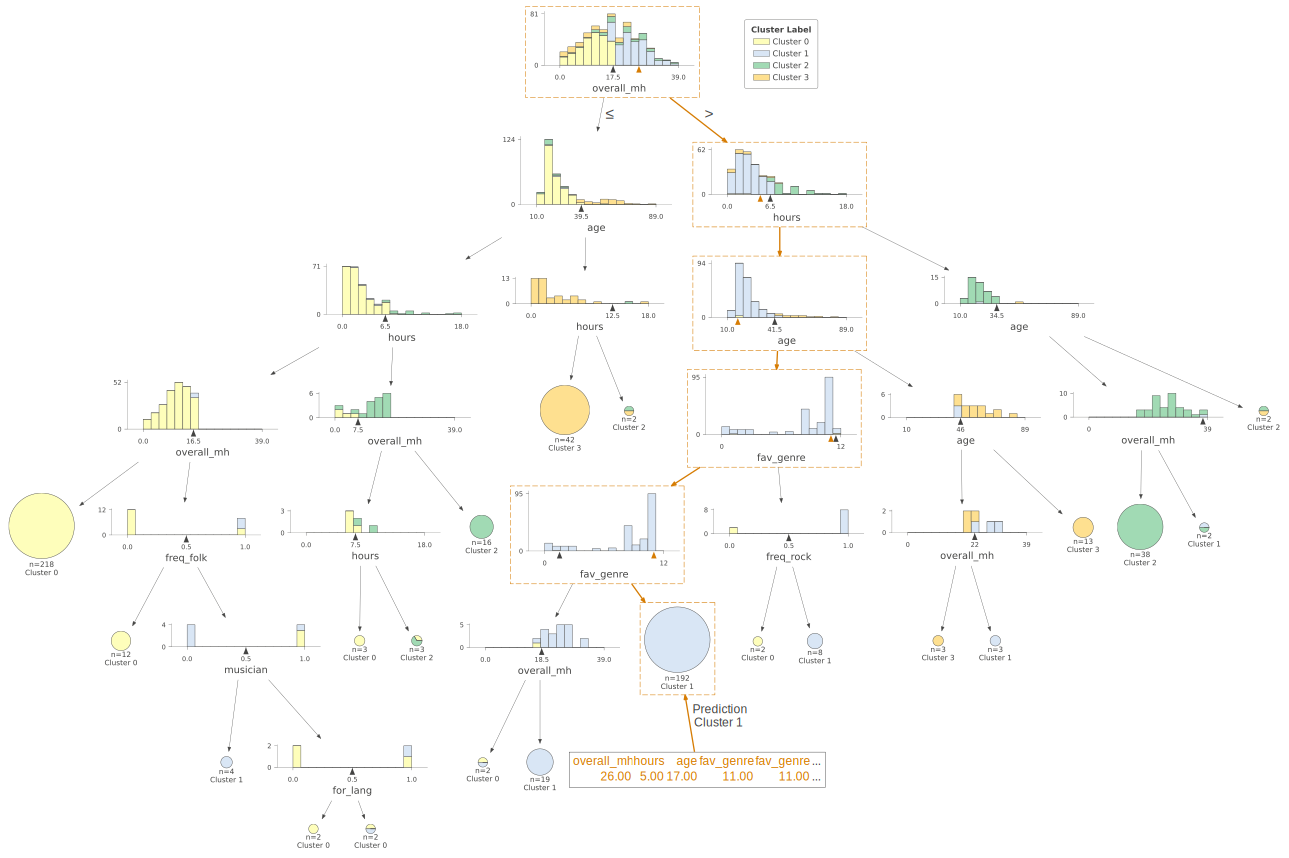

In [13]:
# Application of 'dtreeviz' library for visualization of above results

viz_tree_model = dtreeviz.model(best_model,  # Provide 'best_model' identified earlier by GridSearch CV
                                X_train=feature_train, y_train=target_train,  # Provide training data on which to "apply" this model (for viz)
                                target_name='Cluster Label',  # Provide a Title for the key of Result classifications
                                feature_names=list(feature_set.columns),  # Provide Names for the set of decision branches
                                class_names=['Cluster 0','Cluster 1', 'Cluster 2', 'Cluster 3'])  # Provide Names for the Result classifications

# View the visualization of this decision-tree classifier inline,
# and provide arguments that have it demonstrate application on a data point as well as scale the image up
viz_tree_model.view(x=feature_train.iloc[333], scale=1.1)

# NOTE: Since we're using only the Training set from above data, our total data points are down to 588 from original 736

In [14]:
v = viz_tree_model.view(x=feature_train.iloc[333], scale=1.1)

v.save('music_mh_decisiontree.svg') # This file format is the only one available through dtreeviz itself

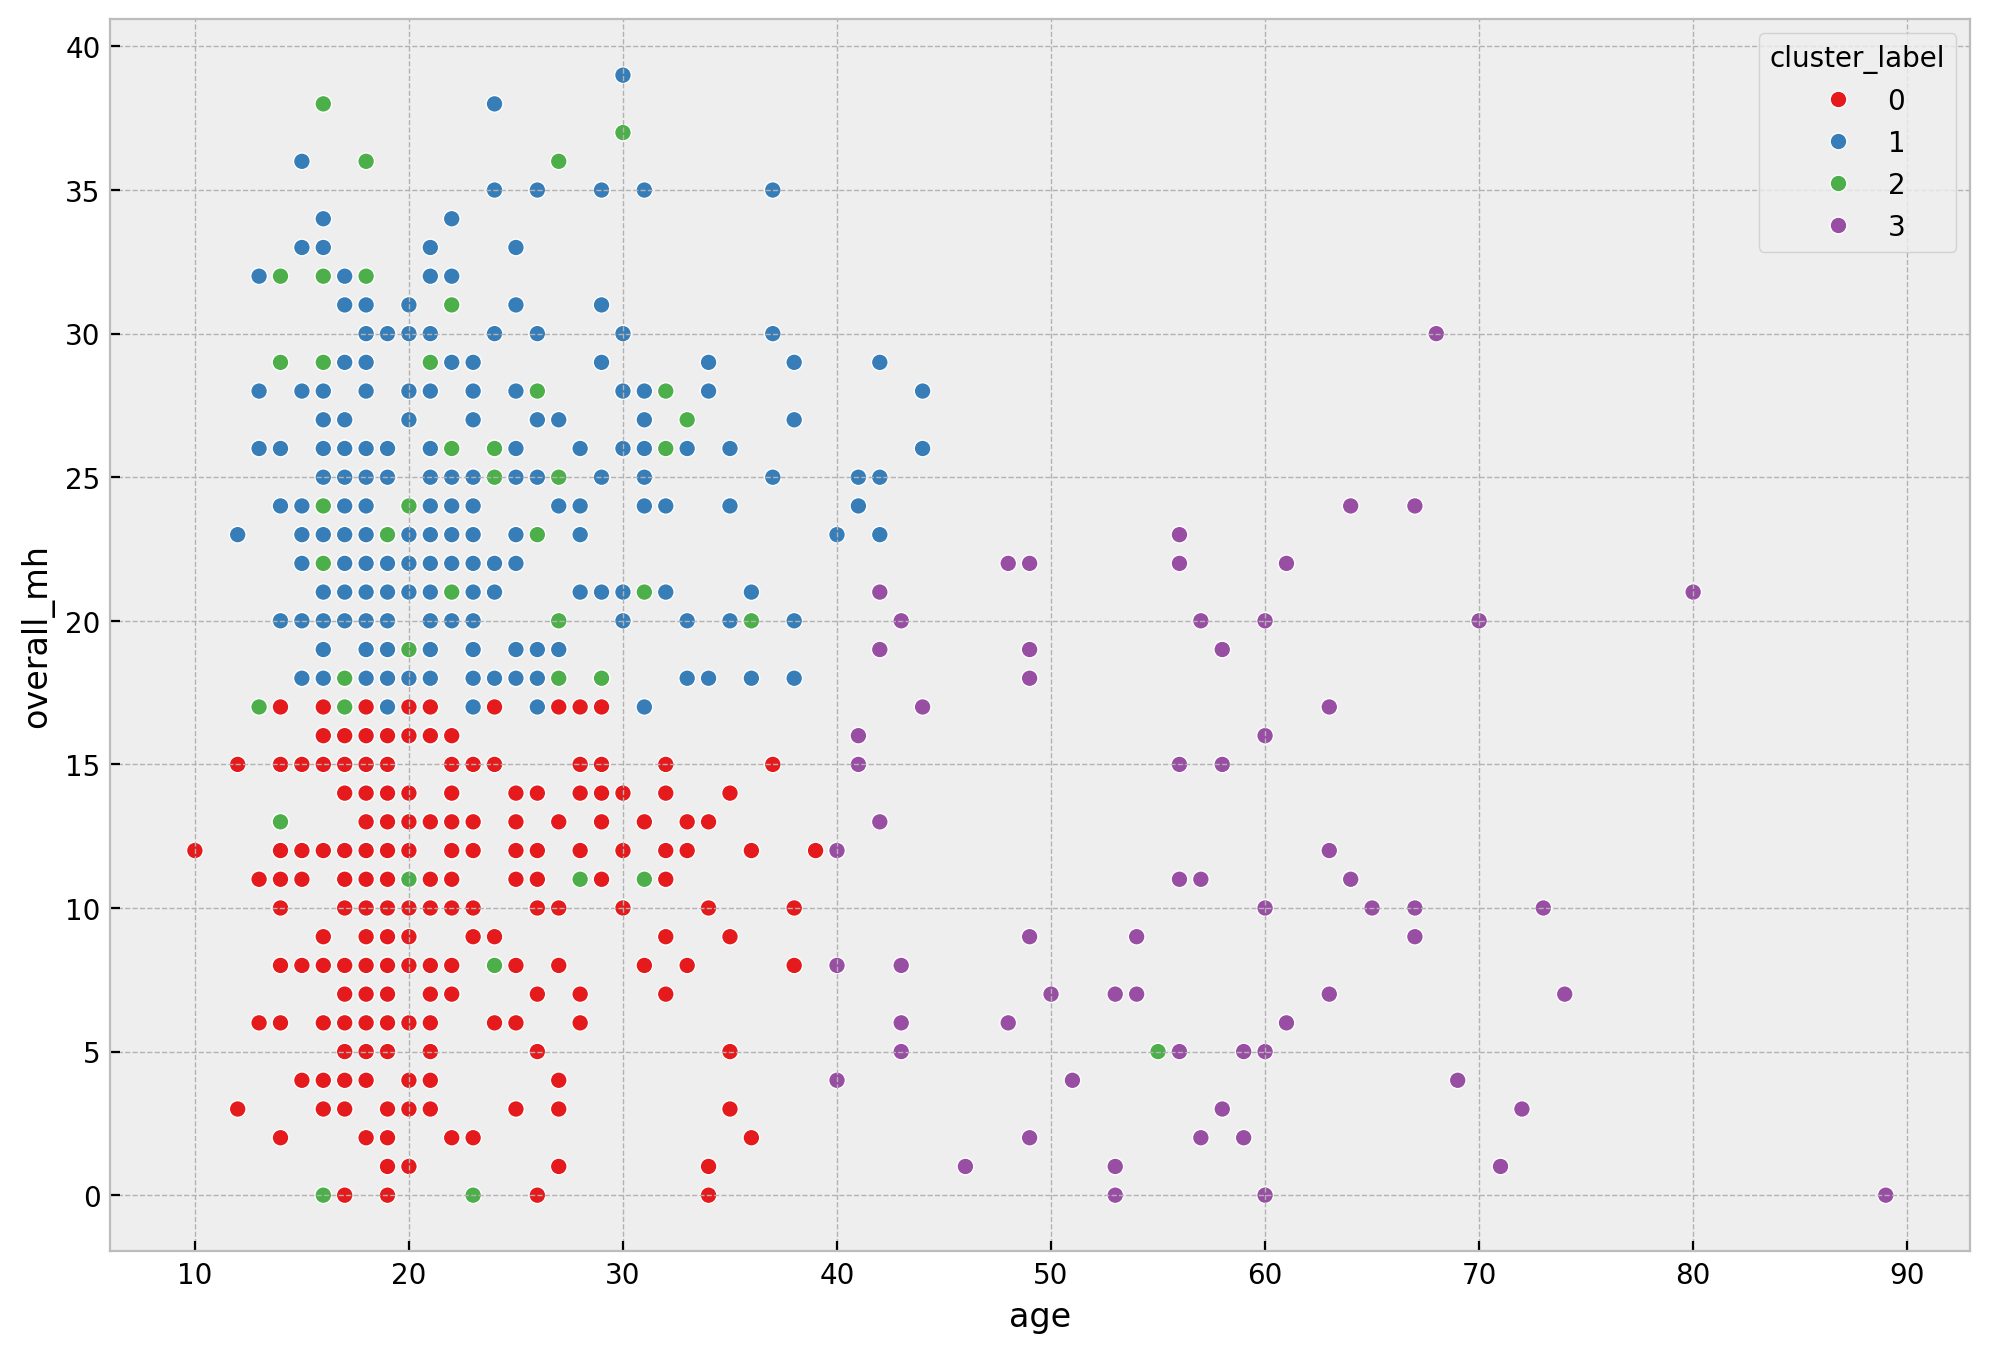

In [15]:
# Constructing various visualizations to communicate this new cluster-based approach

# Plotting all clusters, 'overall_mh' as function of 'age'
with plt.style.context('bmh'):
  # Nothing fancy here, except maybe implicit 'x' and 'y' designation after 'data=df'
  fig0 = plt.figure(figsize=(12,8))
  sns.scatterplot(data=df, x='age', y='overall_mh', hue='cluster_label', palette='Set1')
  plt.savefig('music_mh_scatter_mhvage.png')

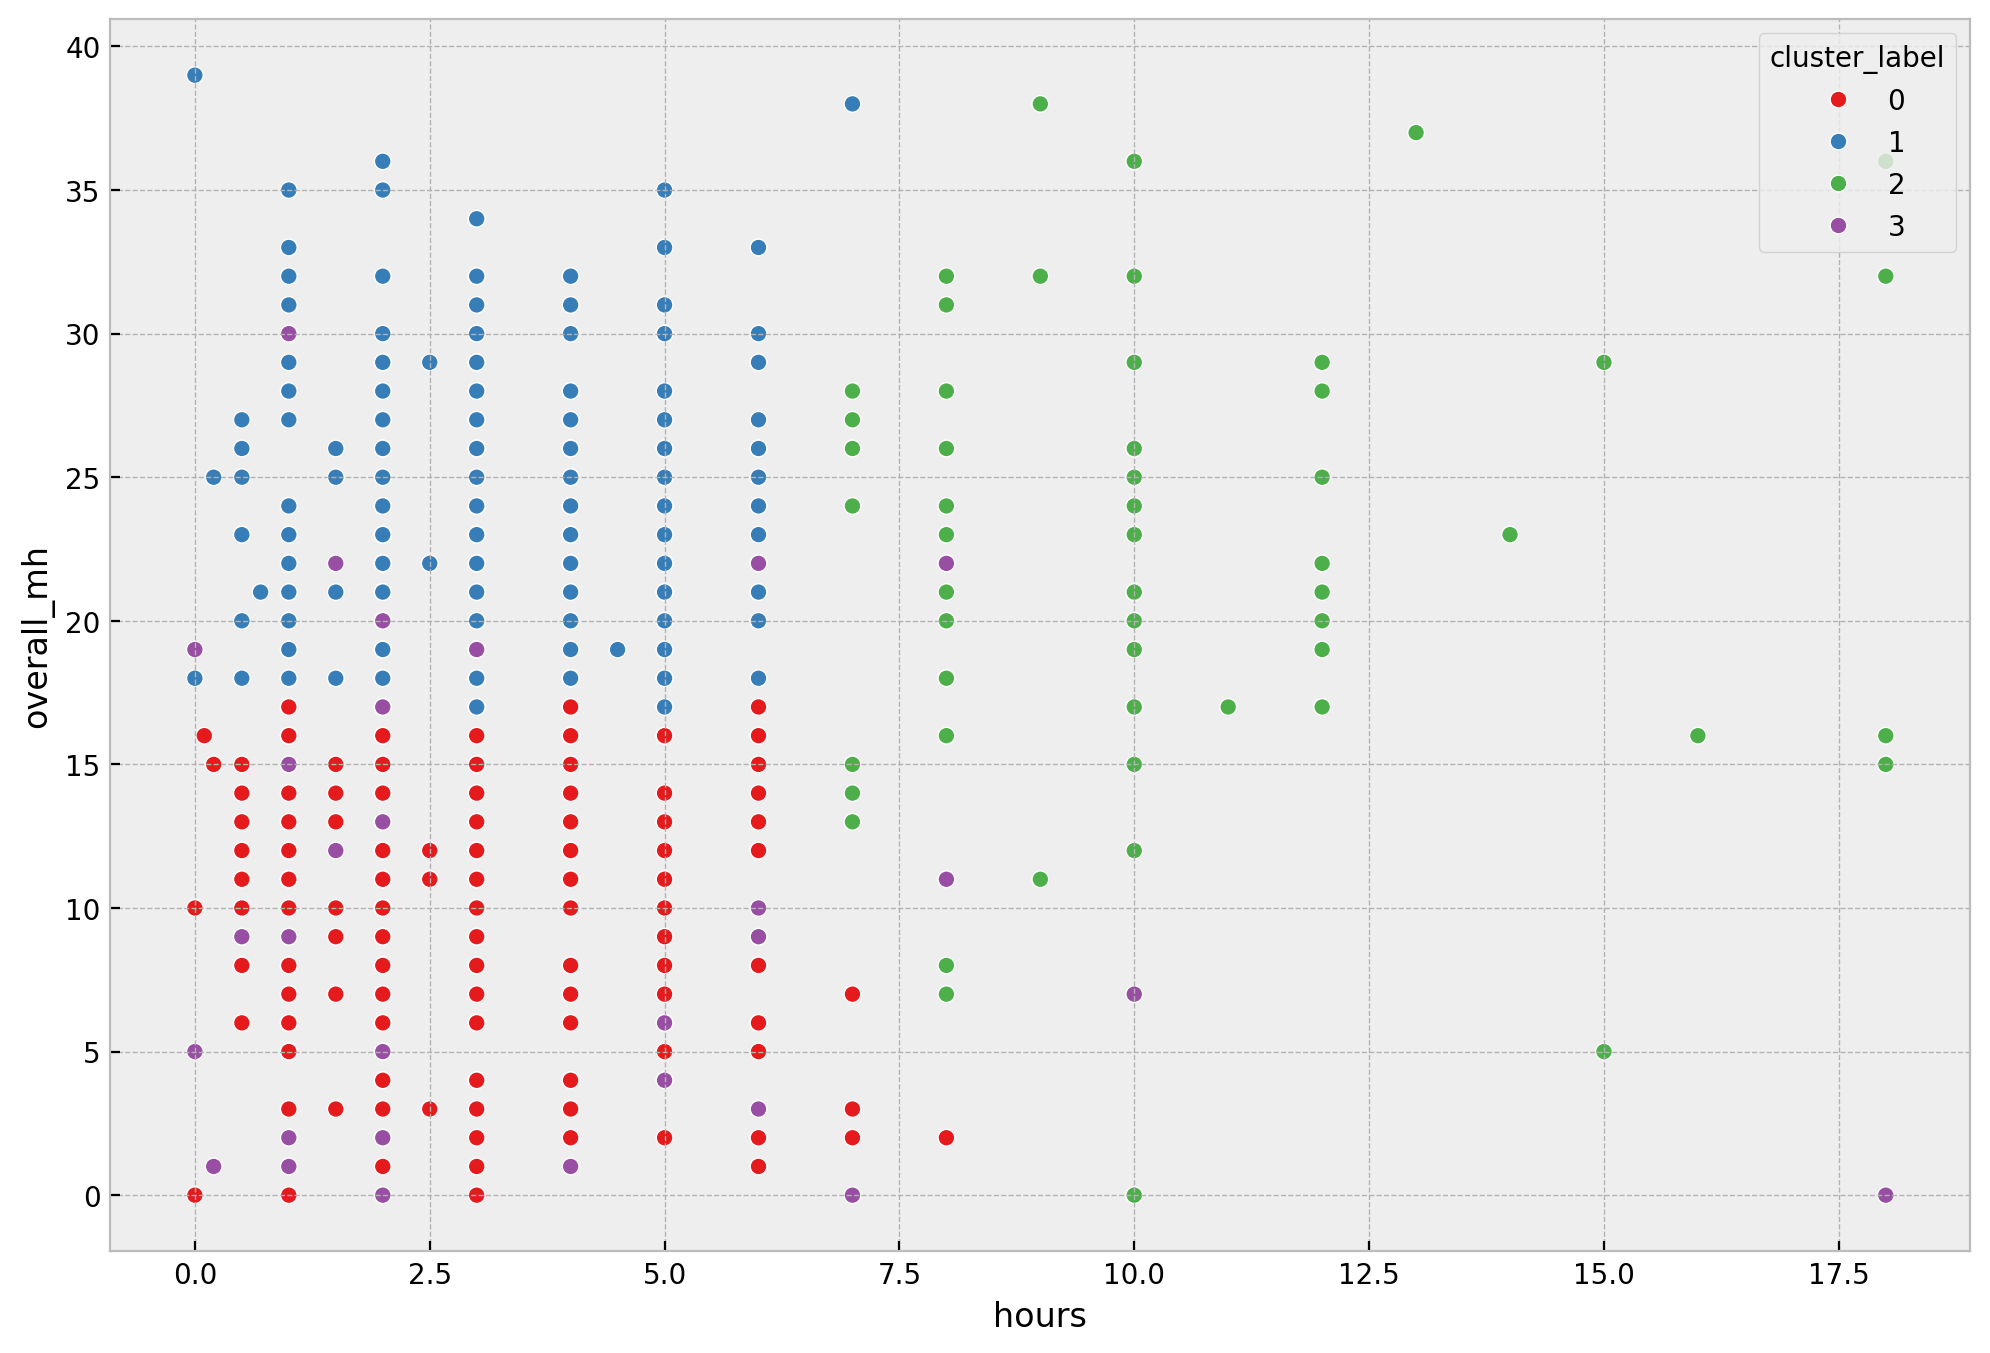

In [16]:
# Plotting all clusters, 'overall_mh' as function of 'hours'
with plt.style.context('bmh'):

  fig1 = plt.figure(figsize=(12,8))
  sns.scatterplot(data=df, x='hours', y='overall_mh', hue='cluster_label', palette='Set1')
  plt.savefig('music_mh_scatter_mhvhours.png')

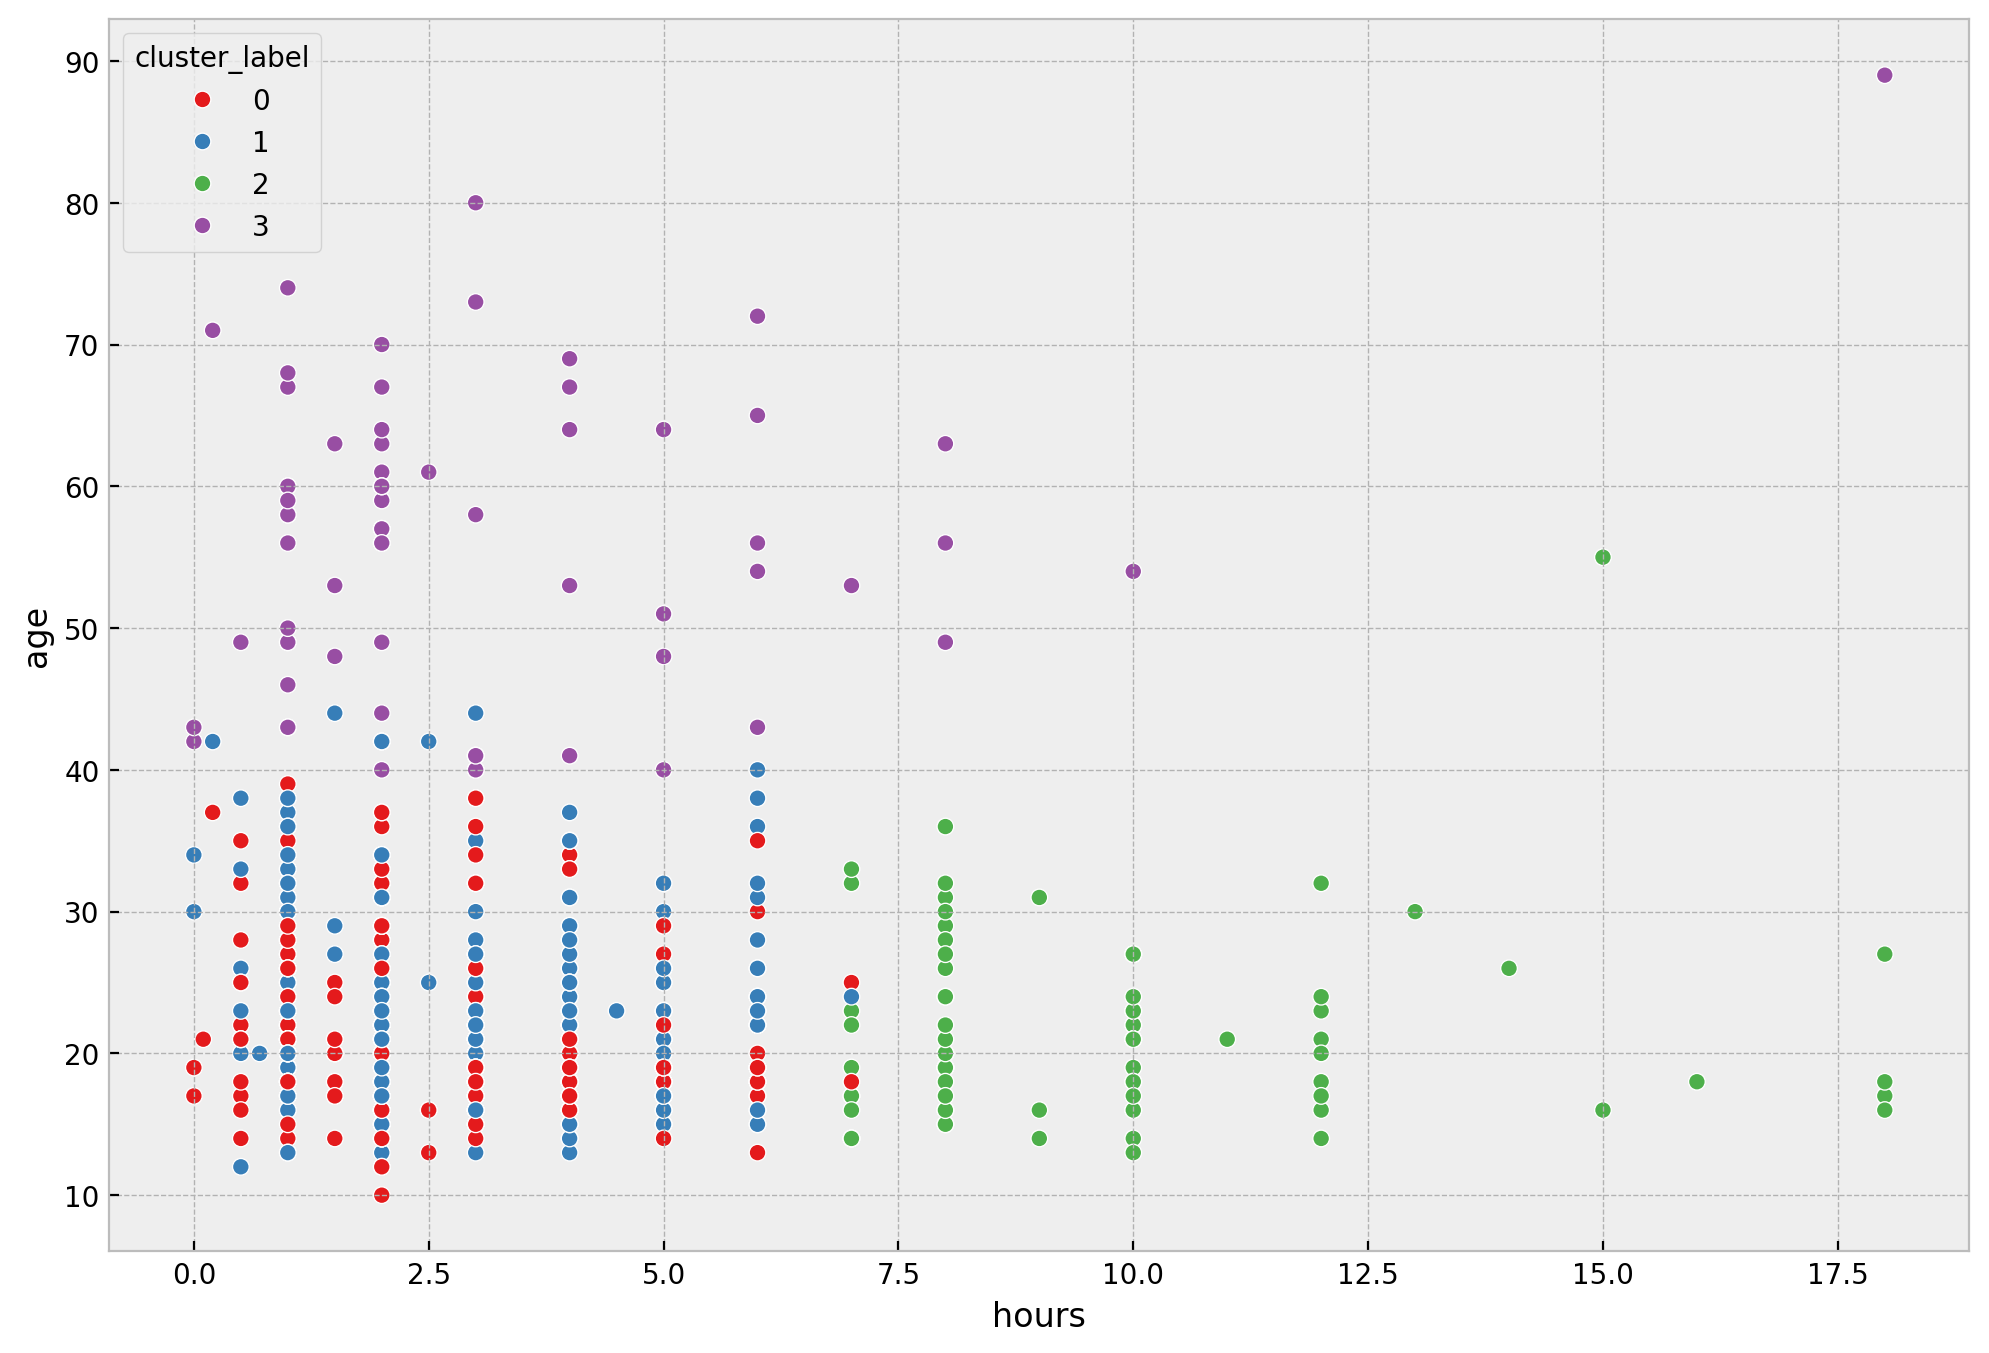

In [17]:
# Plotting all clusters, 'age' as function of 'hours'
with plt.style.context('bmh'):

  fig2 = plt.figure(figsize=(12,8))
  sns.scatterplot(data=df, x='hours', y='age', hue='cluster_label', palette='Set1')
  plt.savefig('music_mh_scatter_agevhours.png')

**NOTE:**
- These three scatterplots might lead one to believe there is meaning to be found in the varying locations of these clusters as they relate to comparisons between our 3 “best” predictors of ‘overall_mh.’
- However, the upcoming boxplots do a better job of demonstrating that this is not necessarily the case.

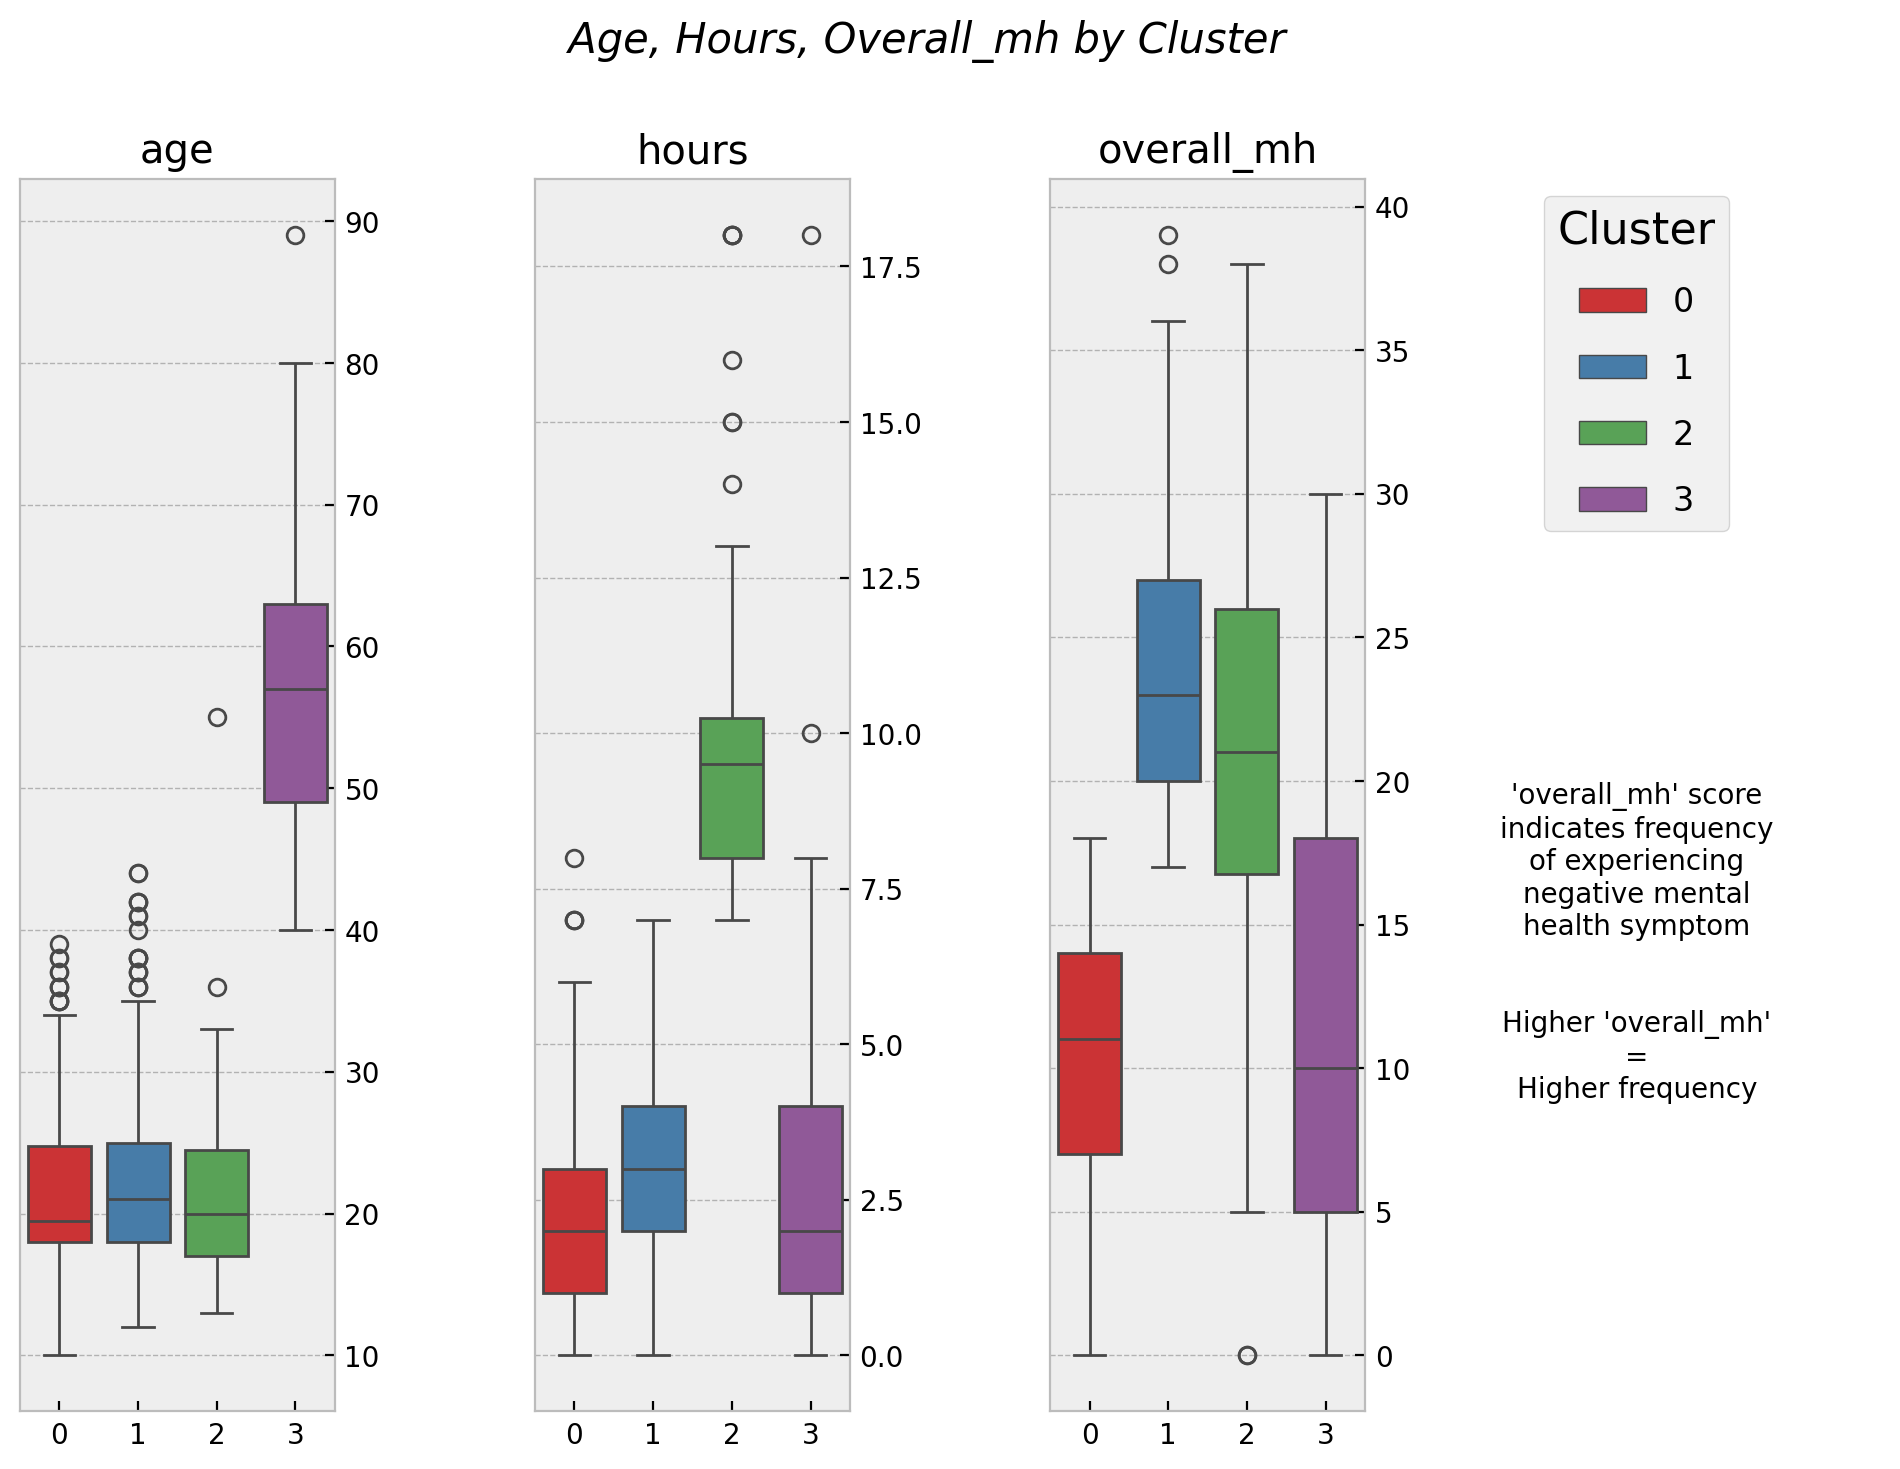

In [18]:
## Plotting by metrics: 'overall_mh', 'age', 'hours' boxplots for all clusters

# Bit more complex approach here for all-in-one side-by-sides
with plt.style.context('bmh'):

  fig3 = plt.figure(figsize=(12, 8))  # Standard 'figure' approach
  gs = fig3.add_gridspec(4, 11)       # Modified with .add_gridspec(nrows, ncols) to slice the figure

  ax_list = []                                    # 'ax_list' will hold our various 'axis' objects as we create them, for future reference
  fields_to_plot = ['age', 'hours', 'overall_mh'] # List of strings of relevant columns from our df. We will index the list as proxy for indexing df

  for idx in range(4):                                                      # Iterate across the "number of axes we intend to create"
    if idx != 3:                                                            # For all axes that aren't the last one
      ax = plt.subplot(gs[:5, (idx * 3):(((idx + 1) * 3) - 1)])             # Place the object in the grispec slices denoted by gs[ : , : ]
                                                                            # As is, we occupy all gridspec rows
                                                                            # We occupy two gridspec columns per axis object, then skip one
      # Apply sns.boxplot to current axis object
      # 'x' is 'cluster_label' from our previous ML ops, 'y' is 'age'/'hours'/'overall_mh' per cluster_label
      # 'hue' by cluster_label, 'dodge'=False to remove space between boxes in given plot, ax=ax to assign to axis object
      sns.boxplot(data=df, x='cluster_label', y=fields_to_plot[idx],
                  hue='cluster_label', palette='Set1', dodge=False, ax=ax)

      ax.get_legend().set_visible(False)                      # Hide the legend for all of our plots
      ax.set(xlabel=None, ylabel=None, title=ax.get_ylabel()) # Hide the labels for both x- and y-axis, set Title for this plot to its old y-axis label
      ax.yaxis.set_ticks_position('right')                    # Move y-axis ticks and labels to right side to better use whitespace and "center" more info

      ax_list.append(ax)  # Add this axis object to the list

    else:                         # For the last axis object
      ax = plt.subplot(gs[:, 8:]) # Place axis object in all columns from 8 onward

      h, l = ax_list[0].get_legend_handles_labels()               # From the first axis object in 'ax_list', unpack the legend handles and labels
      ax.legend(fontsize=12,  title_fontsize=16, labelspacing=1,  # Set the legend for this axis object to the legend handles and labels of ax_list[0]
                handles=h, labels=l, loc=9, title='Cluster')
      mh_str = '\n'.join(("'overall_mh' score",                   # Create a clarifying string to add to the overall figure, joined by \n for spacing
                          "indicates frequency",
                          "of experiencing",
                          "negative mental",
                          "health symptom",
                          "\n",
                          "Higher 'overall_mh'",
                          "=",
                          "Higher frequency"))
      ax.text(0.5, 0.25, mh_str, horizontalalignment='center', verticalalignment='bottom')  # Place that string at the x, y coordinates and alignments desired

      ax.axis('off')      # Turn off elements of this axis object that would normally apply to a graph of any sort
      ax_list.append(ax)  # Add this axis object to the list


  fig3.suptitle(' Age, Hours, Overall_mh by Cluster', fontsize=15, style='oblique')
  plt.savefig('music_mh_boxbycluster.png')

**Mean Mental Health Scores: Binary Genre Classifiers**
- What about mean ‘overall_mh’ scores in terms of our binary genre classifiers?
- Here, the error bars tell the story, which is that “there’s nothing here.”
- Given the magnitude of the error bars in the context of the comparative column heights, it’s clear that these features are very unlikely to be useful as predictors of overall mental health.

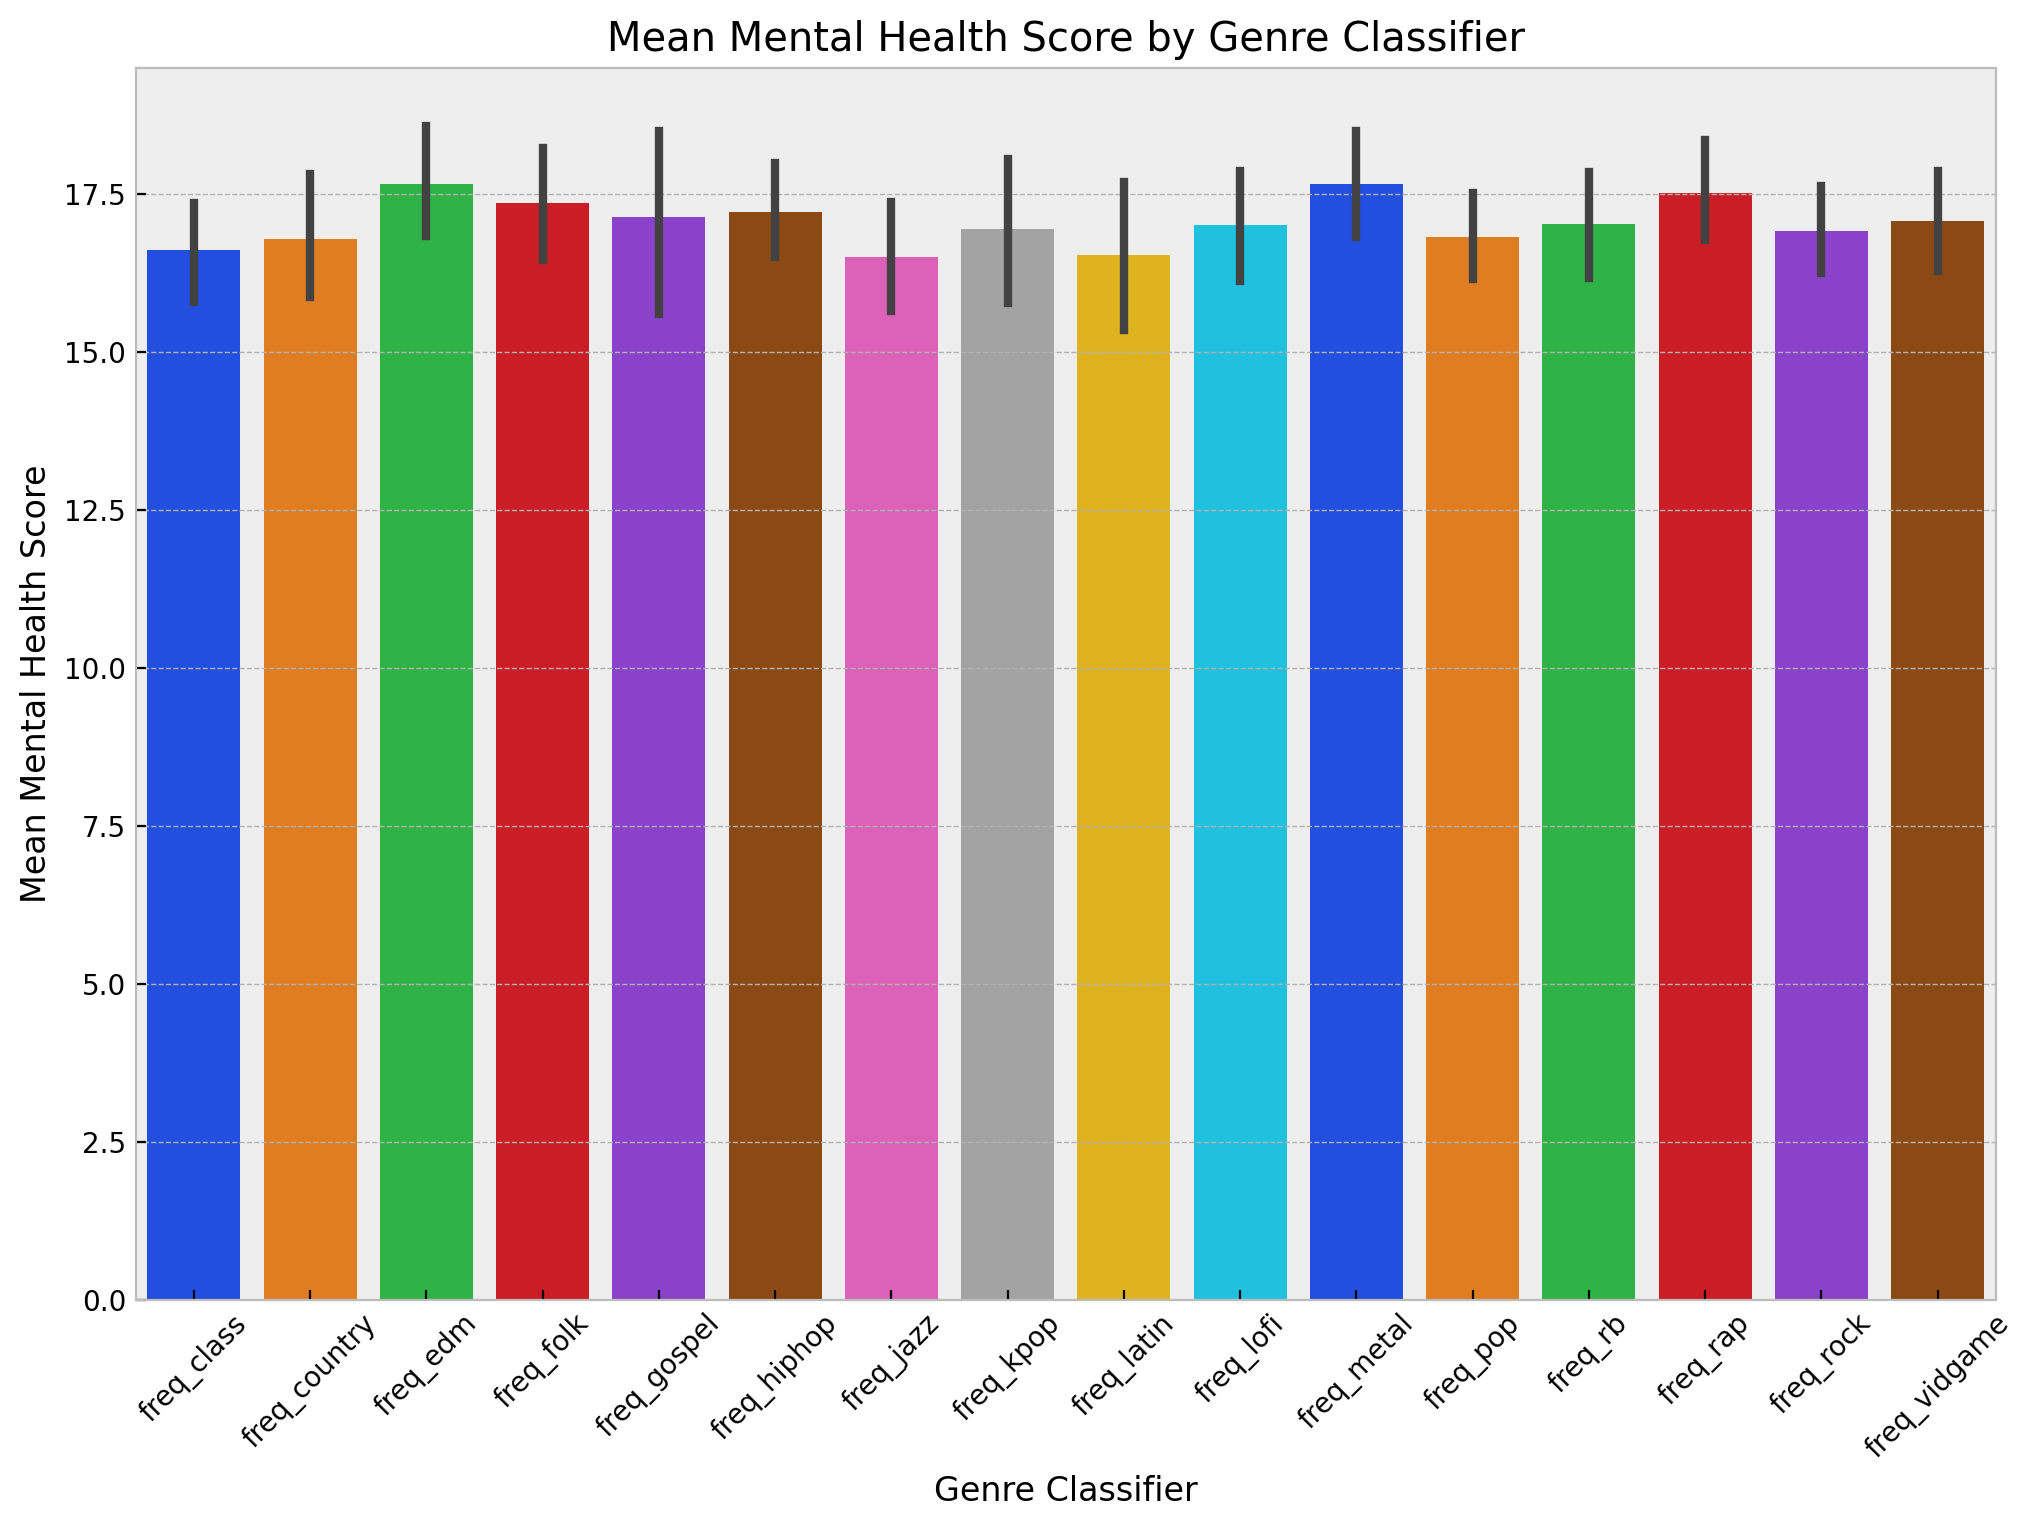

In [19]:
# Assessing mean overall_mh values by genre classifier
freq_cols = [column for column in df.columns if column.startswith('freq')]
# freq_cols  # Print debugging

classifier_means = df.groupby(freq_cols)['overall_mh'].mean().reset_index()  # Calculating grouped means

# Melting the dataframe for Seaborn compatability
melted_means = pd.melt(classifier_means, id_vars='overall_mh', value_vars=freq_cols, var_name='classifier', value_name='presence')

# Filtering out the '0' presence (we want mean scores where the classifier == '1')
melted_means = melted_means[melted_means['presence'] == 1]

with plt.style.context('bmh'):
  # Create Seaborn barplot
  plt.figure(figsize=(12, 8))
  sns.barplot(x='classifier', y='overall_mh', data=melted_means, hue='classifier', palette='bright')
  plt.xlabel('Genre Classifier')
  plt.ylabel('Mean Mental Health Score')
  plt.title('Mean Mental Health Score by Genre Classifier')
  plt.xticks(rotation=45)

  plt.savefig('music_mh_meanmh_bywholegenre.png')
  plt.show()

**Mean Mental Health Scores: Favorite Genre**
- We assessed mean overall mental health values in the context of the single-answer ‘favorite genre’ feature.
- Initially, this plot appears more promising.

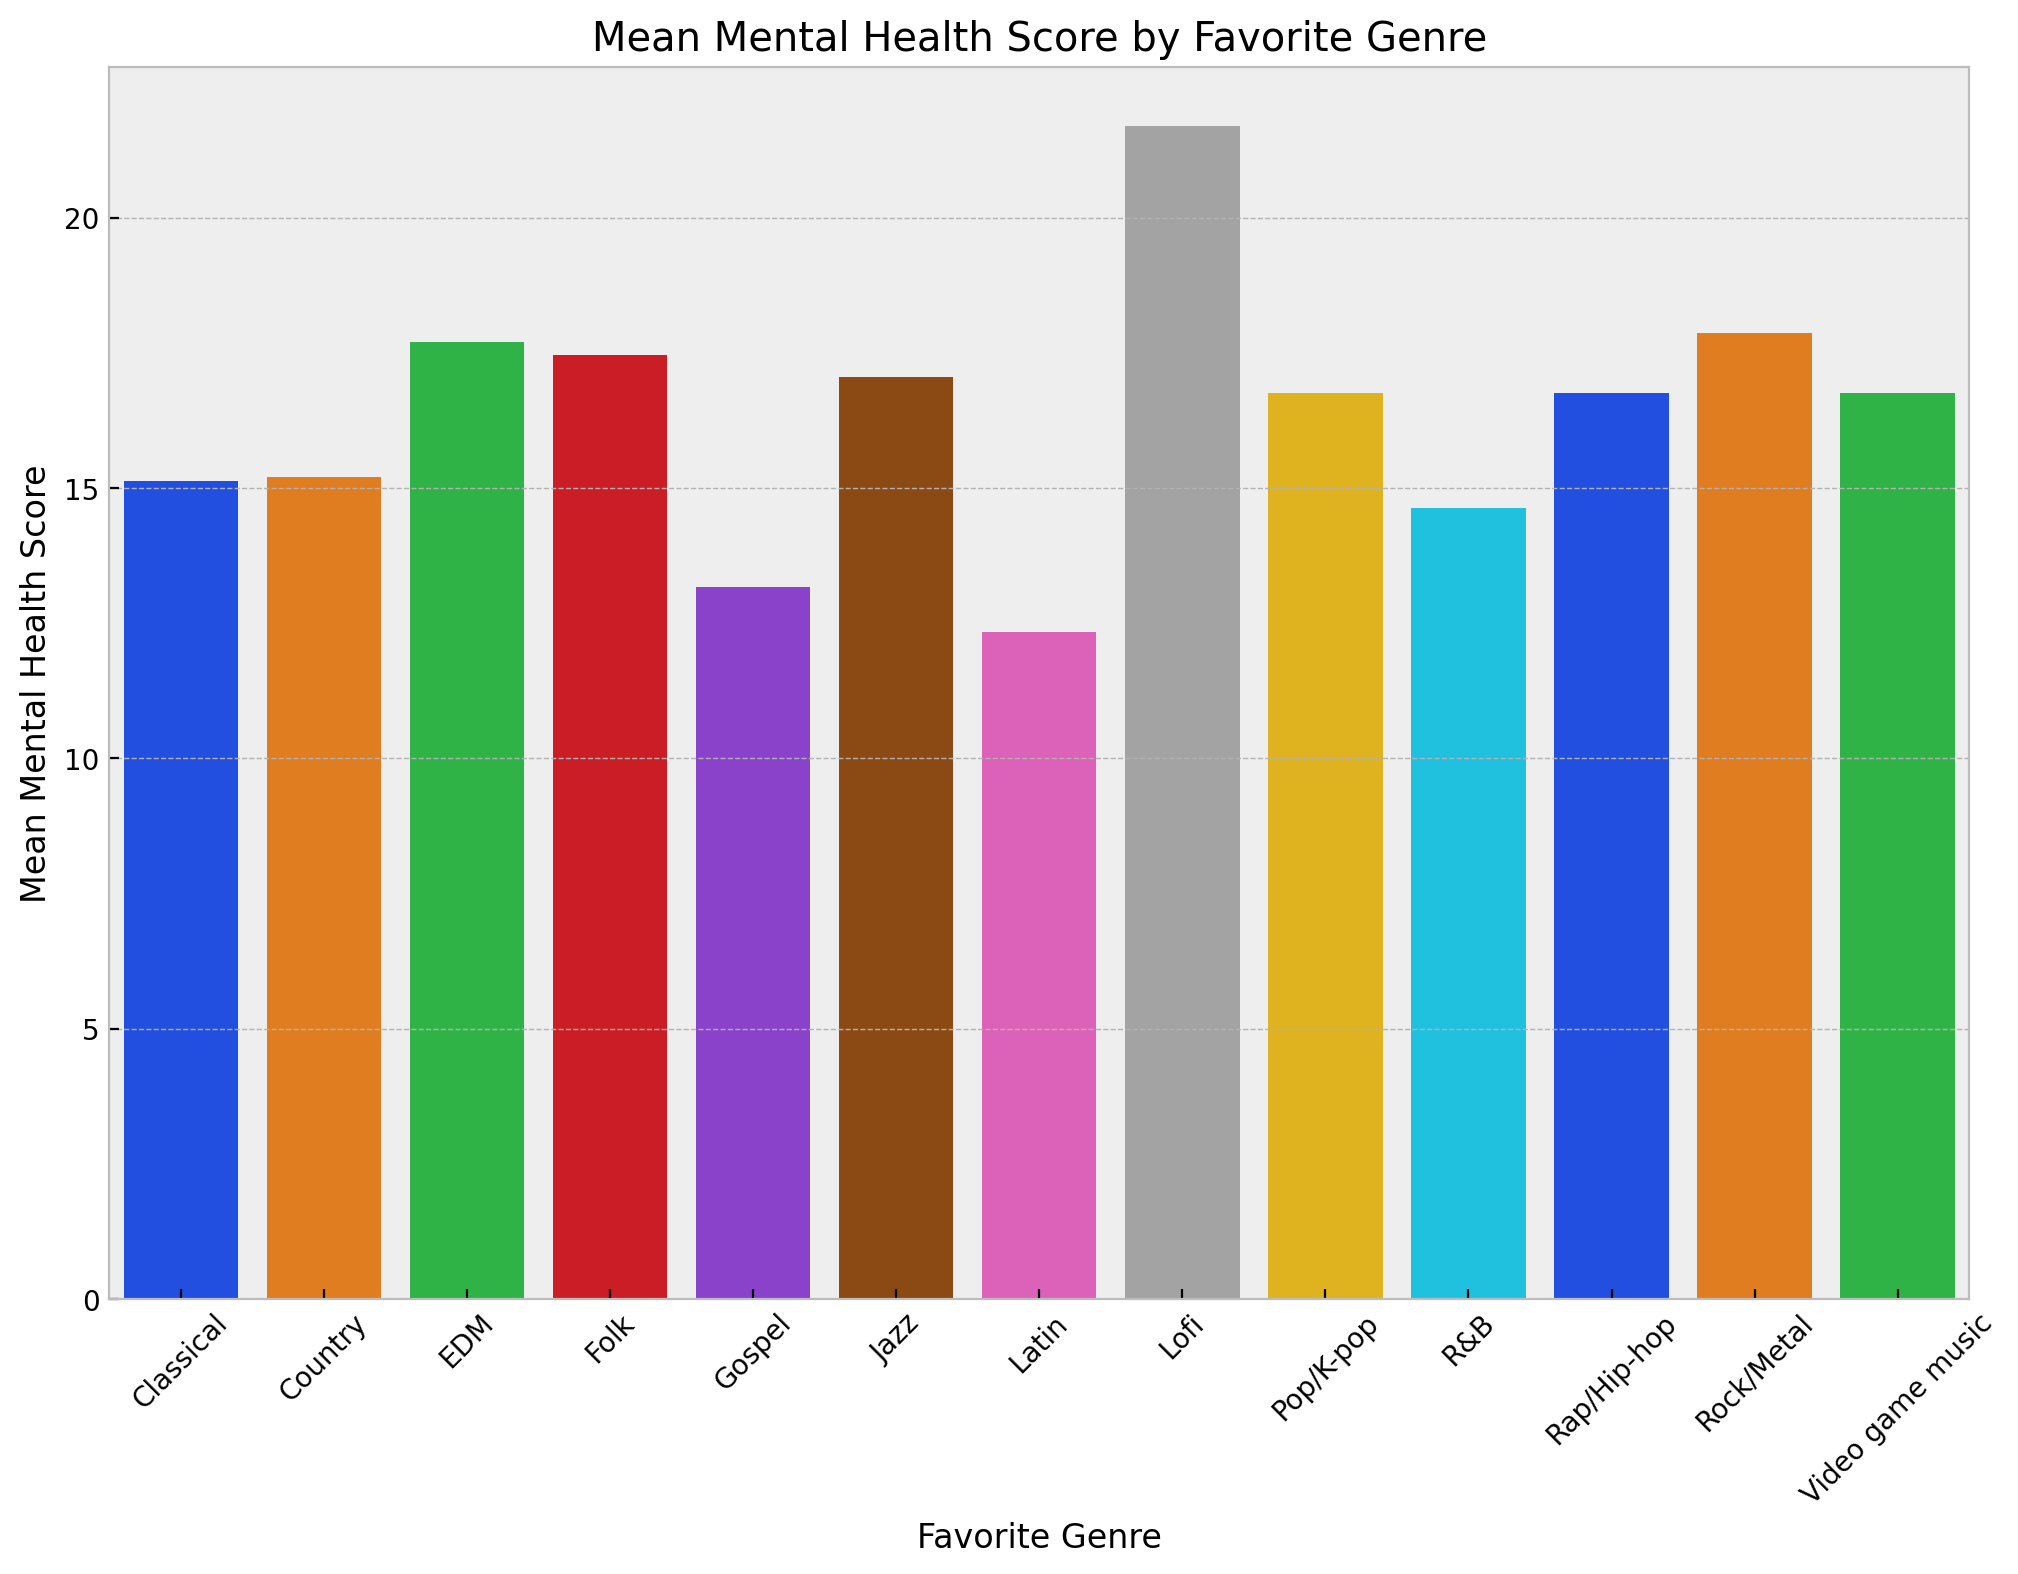

In [20]:
# Assessing mean overall_mh values by single-value favorite genre column
fav_genre_means = df.groupby('fav_genre')['overall_mh'].mean().reset_index()

with plt.style.context('bmh'):
  # Create Seaborn barplot
  plt.figure(figsize=(12, 8))
  sns.barplot(x='fav_genre', y='overall_mh', data=fav_genre_means, hue='fav_genre', palette='bright')
  plt.xlabel('Favorite Genre')
  plt.ylabel('Mean Mental Health Score')
  plt.title('Mean Mental Health Score by Favorite Genre')
  plt.xticks(rotation=45)

  plt.savefig('music_mh_meanmh_byfavgenre.png')
  plt.show()

**However...**

Because our eyes can fool us, it’s always best to seek rigorous quantitative confirmation of what a plot seems to indicate.

In [21]:
# Group 'overall_mh' scores by 'fav_genre'
groups = df.groupby('fav_genre')['overall_mh'].apply(list)

# Perform a one-way ANOVA test using these groups
f_stat, p_value = f_oneway(*groups)

# Print results
print(f'F-statistic: {f_stat:.4f} \nP-value: {p_value:.4f}')

# As expected, the visualization is misleading. Statistically, the mean variance against overall_mh is not significant.

F-statistic: 1.3302 
P-value: 0.1959


**'Giving It a Shot:'**
- We tested several different regressor estimators (not using our cluster label column) to see if any meaningful predictions of overall mental health could be made.
- Even our best predictive model was essentially useless. The R^2 score is statistically indistinguishable from zero.
- This indicates that the model’s predictive power is no better than a ‘trivial model’ which always predicts the average of the target
- The highly-regularized Ridge regressor “won,” likely because our dataset is small, and complex models tend to overfit more.
- The GridSearch likely chose a highly-regularized model because it assessed that the majority of our data, in this predictive context, is functionally just “noise.”
- We therefore concluded that without further differentiating among the clusters, no useful predictions could be made using our data.

In [22]:
# Clone dataframe for regressors
df_reg = df.copy()
# Drop cluster label column
df_reg.drop(columns='cluster_label', inplace=True)

# Create feature and target sets
feature_set = df_reg.drop(columns='overall_mh')
target_set = df_reg['overall_mh']
feature_train, feature_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.2, random_state=4)

# Create column lists by type to pass to transformers and pipeline
reg_num_cols = ['age', 'hours']
reg_cat_cols = ['prim_stream', 'fav_genre']

# Call scaler and one-hot encoder
preprocessor = ColumnTransformer(transformers=[ ('num', StandardScaler(), reg_num_cols), ('cat', OneHotEncoder(), reg_cat_cols) ])  # Build preprocessor

# I can make a list of tuples to store all the estimators that I want to run
# We're going to run them all with their default parameters
estimators = [
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=4)),
    ('Random Forest Regressor', RandomForestRegressor(random_state=4)),
    ('Lasso Regressor', Lasso(random_state=4)),
    ('Ridge Regressor', Ridge(random_state=4)),
    ('SGD Regressor', SGDRegressor(random_state=4)),
    ('Bagging Regressor', BaggingRegressor(random_state=4))
]

scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error'}  # Define the cross-validation metrics in a dictionary

score_table = PrettyTable()  # Instantiate the score table
score_table.field_names = ['Model', 'Mean R2', 'Mean MSE', 'Mean RMSE']  # Define field names in table

for name, estimator in estimators:
    pipe = Pipeline([('preprocessor', preprocessor), ('model', estimator)])

    cv_results = cross_validate(pipe, feature_train, target_train, cv=5, scoring=scoring, return_train_score=False)

    r2_scores = cv_results['test_R2']
    mse_scores = -cv_results['test_MSE']
    rmse_scores = np.sqrt(-cv_results['test_MSE'])

    # Add results for each estimator to the score table
    score_table.add_row([
        name,
        f'{np.mean(r2_scores):.6f}',
        f'{np.mean(mse_scores):.6f}',
        f'{np.mean(rmse_scores):.6f}'])


print(score_table)

+-------------------------+-----------+------------+-----------+
|          Model          |  Mean R2  |  Mean MSE  | Mean RMSE |
+-------------------------+-----------+------------+-----------+
| Decision Tree Regressor | -0.765000 | 119.845068 | 10.937583 |
| Random Forest Regressor | -0.122647 | 76.476733  |  8.742211 |
|     Lasso Regressor     |  0.001110 | 68.101259  |  8.250156 |
|     Ridge Regressor     |  0.017074 | 66.866939  |  8.175256 |
|      SGD Regressor      |  0.005013 | 67.720702  |  8.227334 |
|    Bagging Regressor    | -0.198423 | 81.712636  |  9.035916 |
+-------------------------+-----------+------------+-----------+


In [23]:
# Tuning the ridge regressor to see if we can improve performance

# Preprocessing & model
pipe = Pipeline([('preprocessor', preprocessor), ('model', Ridge(random_state=4))])

# Define parameter grid
params = {'model__alpha': [0.1, 1, 5, 10, 50, 100, 500, 1000], 'model__solver': ['auto', 'lsqr', 'sparse_cg']}

# Perform grid Search
gs = GridSearchCV(pipe, param_grid=params, cv=5, scoring='neg_mean_squared_error')

# Fit the regressor
gs.fit(feature_train, target_train)

# Define the best model
best_model = gs.best_estimator_

# Make predictions
y_pred = best_model.predict(feature_test)

# Evaluation metrics
r2 = r2_score(target_test, y_pred)
mse = mean_squared_error(target_test, y_pred)
rmse = np.sqrt(mse)

# Print results
print(f'Best parameters: {gs.best_params_}')
print(f'Best CV score: {gs.best_score_:.6f}')
print(f'Test R^2 Score: {r2:.6f}')
print(f'Test RMSE Score: {rmse:.6f}')

Best parameters: {'model__alpha': 100, 'model__solver': 'auto'}
Best CV score: -65.518934
Test R^2 Score: -0.007350
Test RMSE Score: 8.187395


- The conclusion is that even the best predictive model is basically useless.
- The GridSearch chose a highly-regularized model because the data are basically just noise.
- And, because the dataset is small, complex flexible models tend to overfit more. So the rigid model "won."
- The moral of the story is that at this scale of data, i.e. without differentiating among the clusters, we can make no useful predictions.
- In fact, the R^2 value shows that this tuned model is actually worse at predicting overall_mh than guessing that the mean of overall_mh is the true value.
- So, we need to subset out the clusters and reapply these regressor tests.

**Next Steps:**
- At this point, we were aware that the only reasonable next step was to create subsetted datasets using our cluster labels, and to assess whether we could build better models using the subsets which the k-means method had shown to be more similar to each other.
- To that end, we created three new data frames: one containing only the members of the ‘old people’ cluster (df_old), one containing only the members of the ‘high hours’ cluster (df_hours), and one containing the rest of the respondents (df_rest).
- We then repeated the evaluate-and-tune process for a set of regressor estimators on the data frames representing the smaller ‘old people’ and ‘high hours’ clusters.
- Our hope was that because these subsets were smaller and contained respondents who were similar to each other, that we’d be able to build a more powerful estimator, even though we were cognizant of the dangers of overfitting, given a smaller dataset.

In [24]:
# Creating subsetted dataframes
df_old = df.loc[df['cluster_label'] == 3].copy()
df_hours = df.loc[df['cluster_label'] == 2].copy()
df_rest = df.loc[(df['cluster_label'] == 0) | (df['cluster_label'] == 1)].copy()

In [25]:
# Building a function to evaluate various regressor models on the smaller cluster dataframes
def evaluate_models(df, df_name):

    # Drop cluster label column if present
    if 'cluster_label' in df.columns:
        df = df.drop(columns='cluster_label')

    # Create feature and target sets
    feature_set = df.drop(columns='overall_mh')
    target_set = df['overall_mh']
    feature_train, feature_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.2, random_state=4)

    # Create column lists by type for transformations
    reg_num_cols = ['age', 'hours']
    reg_cat_cols = ['prim_stream', 'fav_genre']

    # Define preprocessor
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), reg_num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), reg_cat_cols)
    ])

    # List of estimators to evaluate
    estimators = [
        ('Decision Tree Regressor', DecisionTreeRegressor(random_state=4)),
        ('Random Forest Regressor', RandomForestRegressor(random_state=4)),
        ('Lasso Regressor', Lasso(random_state=4)),
        ('Ridge Regressor', Ridge(random_state=4)),
        ('SGD Regressor', SGDRegressor(max_iter=2000, random_state=4)),
        ('Bagging Regressor', BaggingRegressor(random_state=4))
    ]

    # Scoring criteria
    scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error'}

    # Initialize score table
    score_table = PrettyTable()
    score_table.field_names = ['Model', 'Mean R2', 'Mean MSE', 'Mean RMSE']

    # Evaluate each model
    for name, estimator in estimators:
        pipe = Pipeline([('preprocessor', preprocessor), ('model', estimator)])
        cv_results = cross_validate(pipe, feature_train, target_train, cv=5, scoring=scoring, return_train_score=False)

        r2_scores = cv_results['test_R2']
        mse_scores = -cv_results['test_MSE']
        rmse_scores = np.sqrt(-cv_results['test_MSE'])

        # Add results to the score table
        score_table.add_row([
            name,
            f'{np.mean(r2_scores):.6f}',
            f'{np.mean(mse_scores):.6f}',
            f'{np.mean(rmse_scores):.6f}'])

    print(f"Results for {df_name}:")
    print(score_table)

# Call the function for each DataFrame
evaluate_models(df_old, 'df_old')
evaluate_models(df_hours, 'df_hours')

Results for df_old:
+-------------------------+-----------+------------+-----------+
|          Model          |  Mean R2  |  Mean MSE  | Mean RMSE |
+-------------------------+-----------+------------+-----------+
| Decision Tree Regressor | -1.417822 | 121.400000 | 10.811855 |
| Random Forest Regressor | -0.507330 | 76.643453  |  8.622482 |
|     Lasso Regressor     | -0.063712 | 55.514775  |  7.329852 |
|     Ridge Regressor     | -0.596241 | 82.847505  |  8.944929 |
|      SGD Regressor      | -0.833590 | 93.345169  |  9.504274 |
|    Bagging Regressor    | -0.490699 | 76.804465  |  8.640663 |
+-------------------------+-----------+------------+-----------+
Results for df_hours:
+-------------------------+-----------+------------+-----------+
|          Model          |  Mean R2  |  Mean MSE  | Mean RMSE |
+-------------------------+-----------+------------+-----------+
| Decision Tree Regressor | -2.723219 | 201.700000 | 13.976560 |
| Random Forest Regressor | -0.772744 | 112.2310

In [26]:
# Tuning the lasso regressors to see if we can improve performance on either subsetted dataframe
def tune_lasso_model(df, df_name):
    # Preprocess the dataframe
    df = df.copy()
    if 'cluster_label' in df.columns:
        df.drop(columns='cluster_label', inplace=True)

    # Split the data
    feature_set = df.drop(columns='overall_mh')
    target_set = df['overall_mh']
    feature_train, feature_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.2, random_state=4)

    # Define the preprocessor and pipeline
    reg_num_cols = ['age', 'hours']
    reg_cat_cols = ['prim_stream', 'fav_genre']

    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), reg_num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), reg_cat_cols)
    ])

    pipe = Pipeline([('preprocessor', preprocessor), ('model', Lasso(random_state=4))])

    # Parameter grid for Lasso
    params = {'model__alpha': [0.1, 1, 1.5, 2, 5, 10, 50, 100, 500, 1000]}

    # Grid Search
    gs = GridSearchCV(pipe, param_grid=params, cv=5, scoring='neg_mean_squared_error')
    gs.fit(feature_train, target_train)

    # Evaluation
    best_model = gs.best_estimator_
    y_pred = best_model.predict(feature_test)
    r2 = r2_score(target_test, y_pred)
    mse = mean_squared_error(target_test, y_pred)
    rmse = np.sqrt(mse)

    # Extract feature names
    feature_names = np.concatenate([reg_num_cols, best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(reg_cat_cols)])

    # Extract and print non-zero coefficients and corresponding 'included' features
    non_zero_weights = best_model.named_steps['model'].coef_ != 0
    included_features = feature_names[non_zero_weights]

    # Print results
    print(f"Results for {df_name}:")
    print(f'Best parameters: {gs.best_params_}')
    print(f'Best CV score: {gs.best_score_:.6f}')
    print(f'Test R^2 Score: {r2:.6f}')
    print(f'Test RMSE Score: {rmse:.6f}')
    print('Included features after regularization:', included_features)


tune_lasso_model(df_old, 'df_old')
tune_lasso_model(df_hours, 'df_hours')

Results for df_old:
Best parameters: {'model__alpha': 1}
Best CV score: -55.514775
Test R^2 Score: -0.195027
Test RMSE Score: 7.618672
Included features after regularization: ['hours']
Results for df_hours:
Best parameters: {'model__alpha': 2}
Best CV score: -73.495312
Test R^2 Score: -0.090416
Test RMSE Score: 6.685058
Included features after regularization: []


**More Negative Results:**
- The GridSearch once again selected a highly-regularized Lasso regressor. This was expected given the small sizes of the subsets/clusters.
- Tuning made only a small positive difference in terms of RMSE for df_hours and actually *harmed* the RMSE score for df_old.
- Both models failed to meaningfully capture the variance in the target variable.
- In sum, for the goal of predicting overall_mh, even our best models for these smaller clusters were statistically useless.
- As we can see from the R^2 values, both models fail to capture the variance in the target variable, and both are outperformed by a trivial model that always predicts the average of the target.
- In fact, the lasso model for df_hours ended up including no features whatsoever. (Note the empty list in its ‘included features’ parameter.)

**Reclustering Using df_rest:**
- After seeing that even the smaller subsets of data representing the initial ‘old people’ and ‘high hours’ clusters could not be useful in predicting overall mental health, we decided to re-cluster the remaining data, stored in df_rest, to see if different features (i.e. features other than ‘age,’ ‘hours,’ and ‘overall_mh’) would be useful in differentiating between the clusters.
- This seemed at least *possible,* given that the observations so clearly demarcated by their values for the ‘age’ and ‘hours’ in the original smaller clusters had been removed from the dataset.
- So, we selected an appropriate cluster value, re-clustered using k-means on the df_rest subset, and were hoping to see that the clusters would be defined by other features.
- This would indicate that we had removed the influence of the outlying respondents’ extreme values for ‘age’ and ‘hours.’

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10

age prim_stream  hours  working  instrument  compose         fav_genre  \
0 18.00     spotify   3.00        1           1        1             Latin   
2 18.00     spotify   4.00        0           0        0  Video game music   
4 18.00     spotify   4.00        1           0        0               R&B   
5 18.00     spotify   5.00        1           1        1              Jazz   
6 18.00     youtube   3.00        1           1        0  Video game music   

   explore  for_lang  freq_class  ...  freq_metal  freq_pop  freq_rb  \
0        1         1           1  ...           0         1        1   
2        0         1           0  ...           1         1        0   
4        1         0           0  ...           0         1        1   
5        1         1           1  ...           1         1        1   
6        1         1           1  ...           1         1        1   

   freq_rap  freq_rock  freq_vidgame  mus_effects  musician  overall_mh  \
0         1          0             1            0         1           4   
2         1          1             1            0         0          26   
4         1          0             1            1         0          23   
5         1          1             0            1         1          30   
6         0          0             1            1         1          18   

   cluster_label  
0              1  
2              0  
4              0  
5              0  
6              1  

[5 rows x 29 columns]

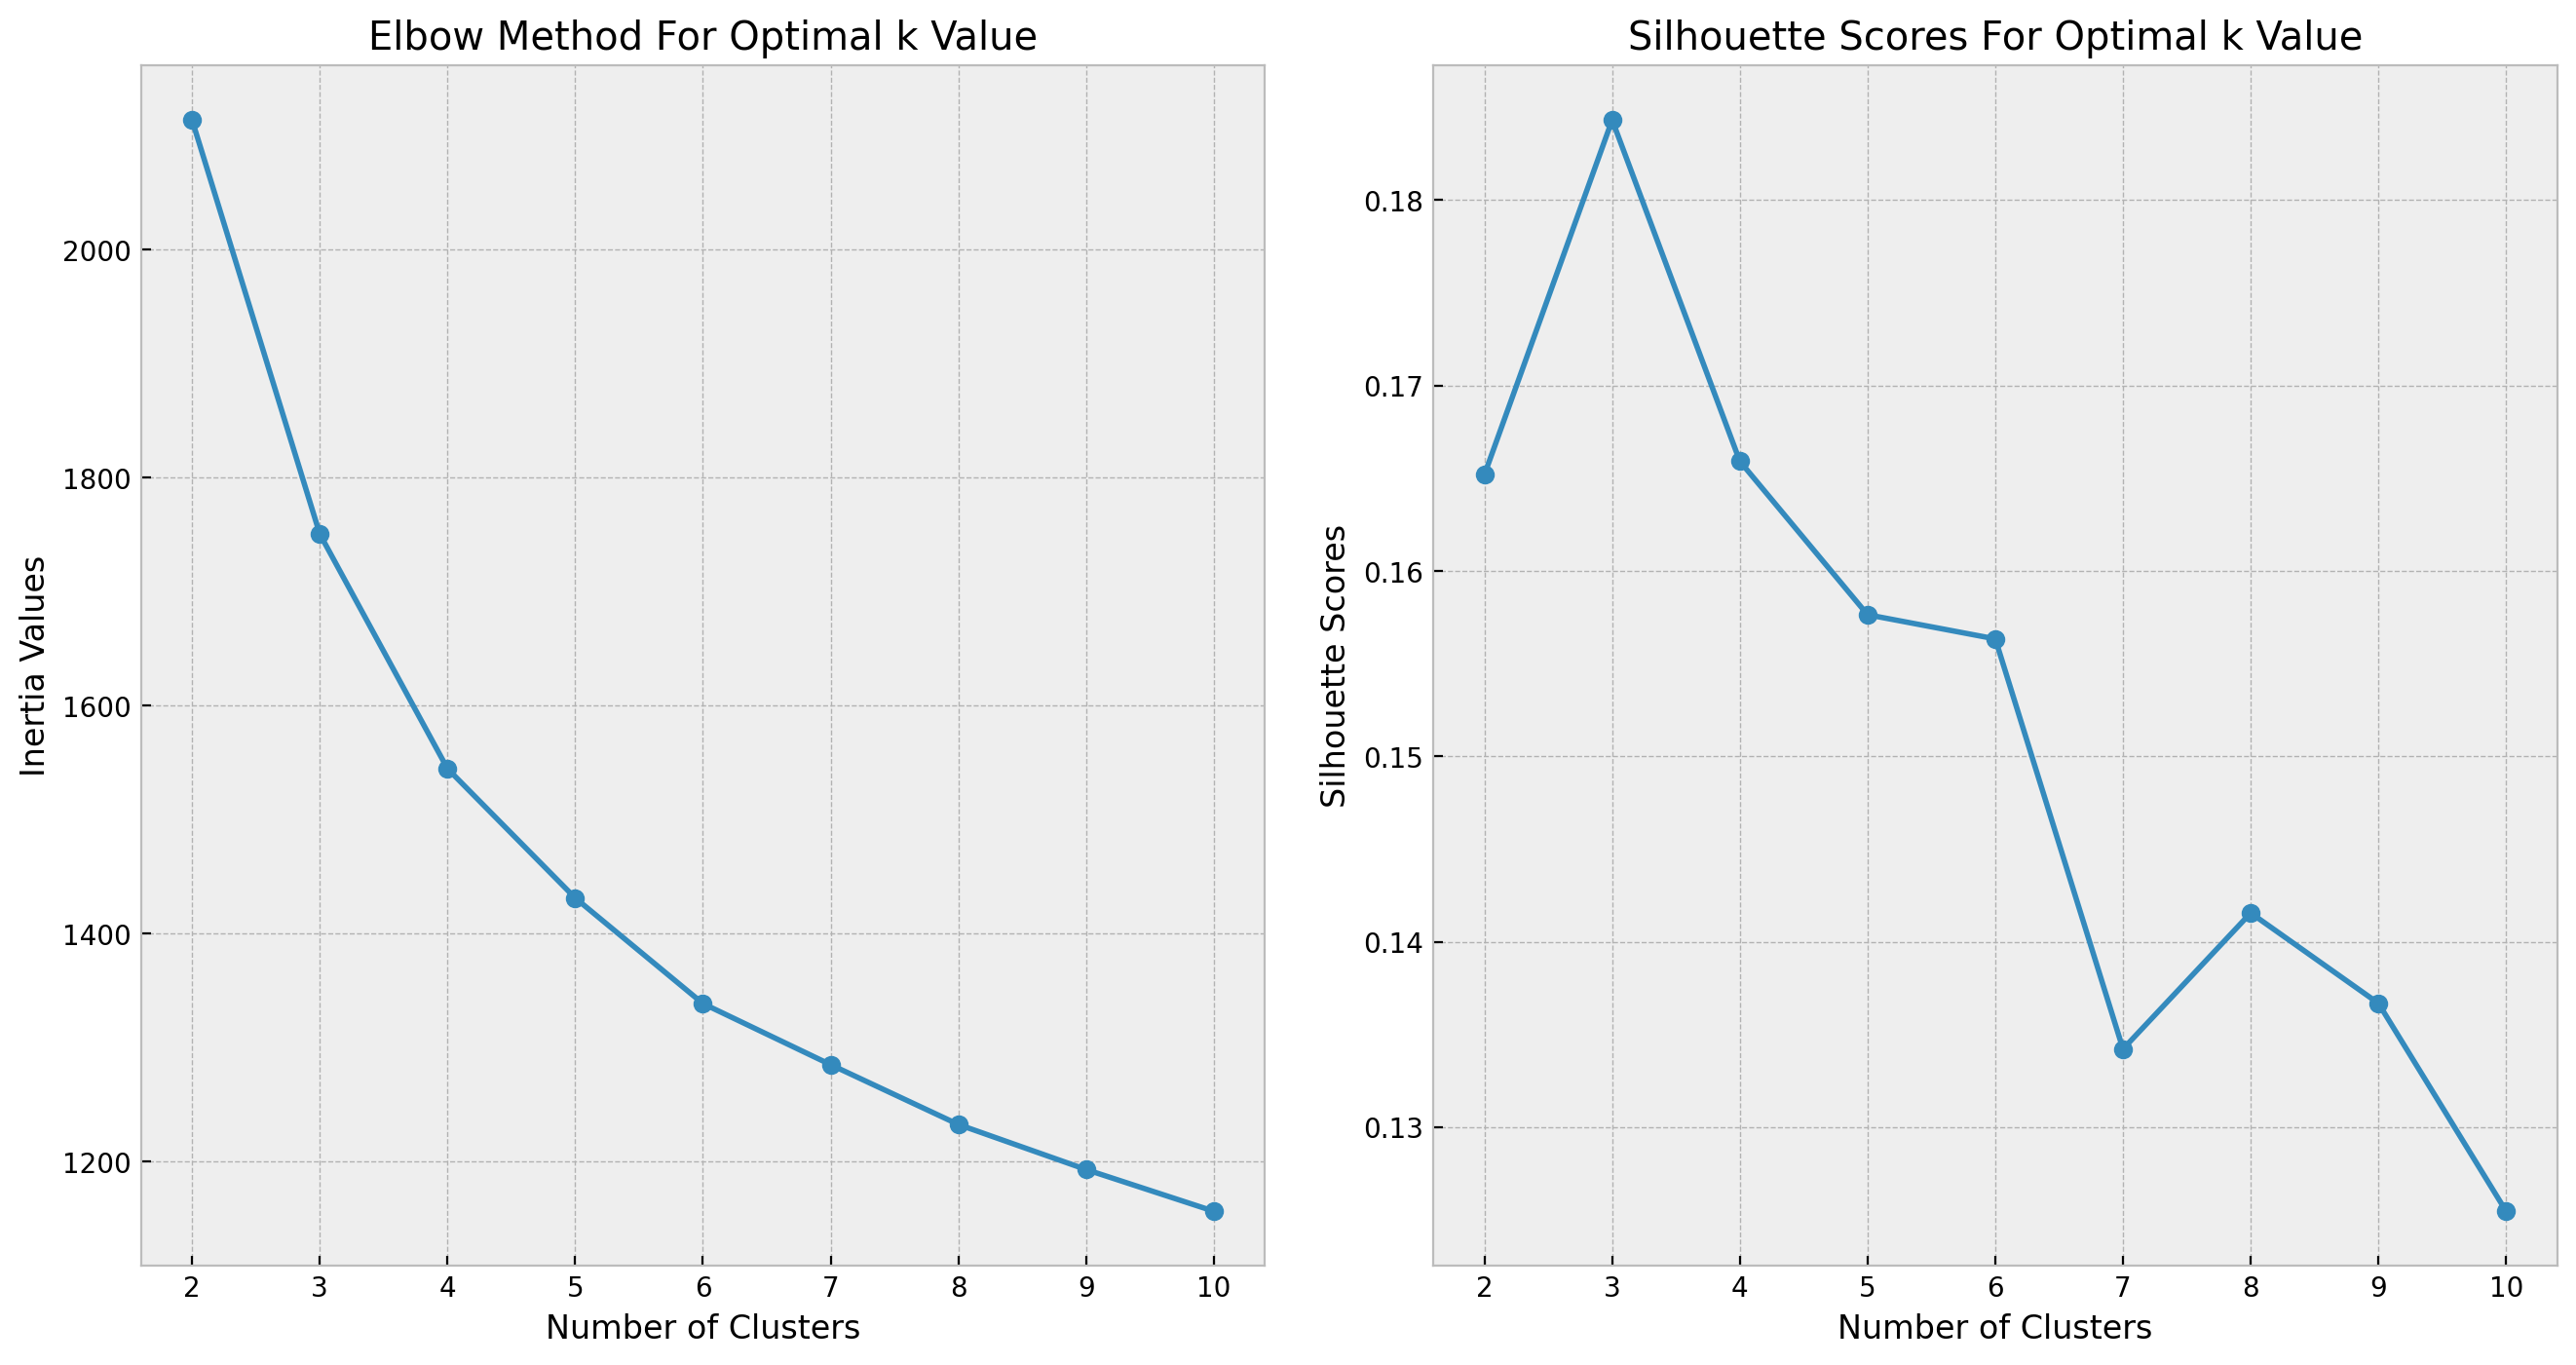

In [27]:
# Unsupervised Machine Learning
# Re-applying k-means to the subsetted df_rest dataframe
# This dataframe contains all respondents who were not sorted into one of the two smaller clusters defined by 'age' and hours'
# The hope is to see whether different features are key differentiators among this subset of respondents

# Step 1: Data Preparation
# Drop old cluster label column
df_rest.drop(columns='cluster_label', inplace=True)

# Define columns requiring transformation
num_cols = ['age', 'hours', 'overall_mh']
cat_cols = ['prim_stream', 'fav_genre']
# NOTE: All binary classifier columns may be left intact for k-means

# Create transformers
num_transform = Pipeline(steps=[('scaler', StandardScaler())])
cat_transform = Pipeline(steps=[('onehot', OneHotEncoder())])

# Combine transformers and create complete column preprocessor
preprocessor = ColumnTransformer(transformers=[('num', num_transform, num_cols), ('cat', cat_transform, cat_cols)])
# NOTE: Binary classifier columns are not included - they don't require transformation

# Call preprocessor and create cluster-ready data
cluster_data = preprocessor.fit_transform(df_rest)

# Step 2: Select the correct number of clusters by calling and comparing the elbow and silhouette score methods
cluster_range = range(2, 11)  # Evaluate possible cluster range from 2 to 10 clusters

# Initialize empty lists for inertia values and silhouette scores
inertia_vals = []
sil_scores =[]

for n_clusters in cluster_range:  # For each potential cluster value in the cluster range
    kmeans = KMeans(n_clusters=n_clusters, random_state=4)  # Fix random state
    cluster_labels = kmeans.fit_predict(cluster_data)  # Fit the kmeans algorithm

    inertia_vals.append(kmeans.inertia_)  # Append the inertia value

    sil_avg = silhouette_score(cluster_data, cluster_labels)  # Compute the silhouette score
    sil_scores.append(sil_avg)  # Append the silhouette score

with plt.style.context('bmh'):
  # Initialize plt.subplots object
  clusterfig, ax = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'wspace':0.15})
  # Plot to apply the elbow method
  ax[0].plot(cluster_range, inertia_vals, marker='o')
  ax[0].set_title('Elbow Method For Optimal k Value')
  ax[0].set_xlabel('Number of Clusters')
  ax[0].set_ylabel('Inertia Values')

  # Plot to assess silhouette scores
  ax[1].plot(cluster_range, sil_scores, marker='o')
  ax[1].set_title('Silhouette Scores For Optimal k Value')
  ax[1].set_xlabel('Number of Clusters')
  ax[1].set_ylabel('Silhouette Scores')

  plt.savefig('music_mh_clusters2.png')

# The elbow method and silhouette score plot indicate that the correct number of clusters is 3 or 4.
# We will privilege the silhouette score and use 3 clusters
# Performing cluster analysis with three clusters

# Create pipeline
pipeline = Pipeline([ ('preprocessor', preprocessor), ('cluster', KMeans(n_clusters=3, random_state=4)) ])

pipeline.fit(df_rest)  # Fit the cluster model with 3 clusters

cluster_labels = pipeline.predict(df_rest)  # Predicting cluster labels for the original data

df_rest['cluster_label'] = cluster_labels  # Add the cluster labels to the DataFrame
df_rest.head()

**At first, there was hope:**

In [28]:
# Analyzing clusters

# Displaying within-cluster counts
df_rest.groupby('cluster_label').size()

# Initially, this is *much* more encouraging. The clusters now are of much more similar sizes.

cluster_label
0    203
1    278
2    110
dtype: int64

**But then:**
- Nothing has meaningfully changed.
- We still have the same three features differentiating among the clusters.
- Despite the removal of the rows in the ‘old people’ and ‘high hours’ clusters, these three features still have overwhelming primacy.
- In fact, when we consider the descriptive statistics, it turns out that we still have one ‘old people’ cluster and one ‘high hours’ cluster.
- Mean scores for overall_mh are *closer,* but that feature is now a *less* useful differentiator in the clustering.

In [29]:
# We can analyze feature importance in terms of cluster differentiation by applying one-way ANOVA tests
anova_columns = [col for col in df_rest.columns if col not in cat_cols and col != 'cluster_label']
anova_outcomes = []  # Initialize an empty list to store ANOVA results

# Perform one-way ANOVA for each numerical feature
for feature in anova_columns:
    # Define the groups (i.e. clusters) for the ANOVA tests
    groups = [df_rest[df_rest['cluster_label'] == cluster][feature] for cluster in df_rest['cluster_label'].unique()]

    result = f_oneway(*groups)  # Perform ANOVA tests

    anova_outcomes.append({'Feature': feature, 'F-Statistic': result.statistic, 'P-Value': result.pvalue})  # Append the results

anova_df = pd.DataFrame(anova_outcomes)  # Convert results to a dataframe
anova_df_sorted = anova_df.sort_values(by='F-Statistic', ascending=False)  # Sort results by F statistic

anova_df_sorted

# The ANOVA results indicate that, in a parallel outcome to our last cluster analysis, the most powerful differentiating features remain age, hours, and overall_mh.
# Despite the fact that the outlying respondents in terms of age and hours were removed from this dataset in our first cluster analysis, those features still hold primacy in differentiation.

Feature  F-Statistic  P-Value
0            age       519.66     0.00
1          hours       396.41     0.00
25    overall_mh        48.07     0.00
2        working        19.56     0.00
17    freq_metal         9.97     0.00
21     freq_rock         9.54     0.00
5        explore         8.22     0.00
10     freq_folk         8.05     0.00
23   mus_effects         6.36     0.00
16     freq_lofi         5.48     0.00
8   freq_country         4.86     0.01
3     instrument         3.78     0.02
24      musician         3.58     0.03
15    freq_latin         2.81     0.06
9       freq_edm         2.63     0.07
4        compose         2.47     0.09
22  freq_vidgame         2.40     0.09
19       freq_rb         2.06     0.13
14     freq_kpop         1.95     0.14
12   freq_hiphop         1.37     0.26
20      freq_rap         1.34     0.26
7     freq_class         1.13     0.32
6       for_lang         0.75     0.47
11   freq_gospel         0.44     0.65
18      freq_pop         0.18     0.84
13     freq_jazz         0.03     0.97

In [30]:
# Let's see if we can reinforce this using feature importance scores as assessed by a decision tree
df_rest_tree_clone = df_rest.copy()

# Encode categorical variable
label_encoder = LabelEncoder()
df_rest_tree_clone['prim_stream'] = label_encoder.fit_transform(df_rest_tree_clone['prim_stream'])
df_rest_tree_clone['fav_genre'] = label_encoder.fit_transform(df_rest_tree_clone['fav_genre'])

# Define features and target variable
feature_set_rest_tree = df_rest_tree_clone.drop(columns=['cluster_label'])
target_set_rest_tree = df_rest_tree_clone['cluster_label']

# Split into training and test sets
feature_train_rest_tree, feature_test_rest_tree, target_train_rest_tree, target_test_rest_tree = train_test_split(feature_set_rest_tree, target_set_rest_tree, test_size=0.2, random_state=4)

# Parameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize a Decision Tree Classifier and GridSearchCV
decision_tree = DecisionTreeClassifier(random_state=4)
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='f1_weighted')

grid_search.fit(feature_train_rest_tree, target_train_rest_tree)  # Train the model

print("Best parameters found: ", grid_search.best_params_)  # Fetch the best parameter set
best_model = grid_search.best_estimator_  # Fetch the best estimator
y_pred = best_model.predict(feature_test_rest_tree)  # Make predictions using the best model
report = classification_report(target_test_rest_tree, y_pred)  # Assess the best model's performance
conf_matrix = confusion_matrix(target_test_rest_tree, y_pred)  # Generate a confusion matrix

# Fetch the feature importances from the best model
feature_importances = pd.DataFrame(best_model.feature_importances_, index=feature_train_rest_tree.columns, columns=['importance']).sort_values('importance', ascending=False)

print('Classification Report:\n', report)
print()
print('Confusion Matrix:\n', conf_matrix)
print()
print('Feature Importances:\n', feature_importances)

# The results from the earlier ANOVA tests are exactly reinforced

Best parameters found:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        45
           1       0.95      1.00      0.97        53
           2       1.00      0.86      0.92        21

    accuracy                           0.96       119
   macro avg       0.97      0.94      0.95       119
weighted avg       0.96      0.96      0.96       119


Confusion Matrix:
 [[43  2  0]
 [ 0 53  0]
 [ 2  1 18]]

Feature Importances:
               importance
hours               0.43
age                 0.41
overall_mh          0.16
freq_latin          0.00
working             0.00
freq_kpop           0.00
musician            0.00
mus_effects         0.00
freq_vidgame        0.00
freq_rock           0.00
freq_rap            0.00
freq_rb             0.00
freq_pop            0.00
freq_metal          0.00
freq_lofi           0.00

In [31]:
# Subsequent numerical analysis of these features

# Define an aggregation dictionary
aggs = {
    'age': ['min', 'mean', 'max', 'std'],
    'overall_mh': ['min', 'mean', 'max', 'std'],
    'hours': ['min', 'mean', 'max', 'std']
}

# Group the DataFrame by 'cluster_label' and apply the aggregations
cluster_summary = df_rest.groupby('cluster_label').agg(aggs)

# Flatten multi-index columns for readability
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]

# Re-present cluster membership counts
print(df_rest.groupby('cluster_label').size())
print()
# Display transposed table with two decimal places
pd.set_option('display.float_format', '{:.2f}'.format)
print(cluster_summary.transpose())

# We once again have one 'older' cluster, one 'higher hours' cluster, and more-similar mean values for overall_mh

cluster_label
0    203
1    278
2    110
dtype: int64

cluster_label       0     1     2
age_min         13.00 10.00 24.00
age_mean        20.04 19.42 32.33
age_max         32.00 28.00 44.00
age_std          3.77  3.31  4.53
overall_mh_min   1.00  0.00  0.00
overall_mh_mean 20.32 13.96 19.26
overall_mh_max  38.00 32.00 39.00
overall_mh_std   7.82  6.86  8.22
hours_min        2.00  0.00  0.00
hours_mean       4.46  1.87  2.04
hours_max        8.00  4.00  6.00
hours_std        1.14  0.81  1.32


**One more try with regressors:**

In [32]:
def evaluate_models(df, df_name):

    # Drop cluster label column if present
    if 'cluster_label' in df.columns:
        df = df.drop(columns='cluster_label')

    # Create feature and target sets
    feature_set = df.drop(columns='overall_mh')
    target_set = df['overall_mh']
    feature_train, feature_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.2, random_state=4)

    # Create column lists by type for transformations
    reg_num_cols = ['age', 'hours']
    reg_cat_cols = ['prim_stream', 'fav_genre']

    # Define preprocessor
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), reg_num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), reg_cat_cols)
    ])

    # List of estimators to evaluate
    estimators = [
        ('Decision Tree Regressor', DecisionTreeRegressor(random_state=4)),
        ('Random Forest Regressor', RandomForestRegressor(random_state=4)),
        ('Lasso Regressor', Lasso(random_state=4)),
        ('Ridge Regressor', Ridge(random_state=4)),
        ('SGD Regressor', SGDRegressor(max_iter=2000, random_state=4)),
        ('Bagging Regressor', BaggingRegressor(random_state=4))
    ]

    # Scoring criteria
    scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error'}

    # Initialize score table
    score_table = PrettyTable()
    score_table.field_names = ['Model', 'Mean R2', 'Mean MSE', 'Mean RMSE']

    # Evaluate each model
    for name, estimator in estimators:
        pipe = Pipeline([('preprocessor', preprocessor), ('model', estimator)])
        cv_results = cross_validate(pipe, feature_train, target_train, cv=5, scoring=scoring, return_train_score=False)

        r2_scores = cv_results['test_R2']
        mse_scores = -cv_results['test_MSE']
        rmse_scores = np.sqrt(-cv_results['test_MSE'])

        # Add results to the score table
        score_table.add_row([
            name,
            f'{np.mean(r2_scores):.6f}',
            f'{np.mean(mse_scores):.6f}',
            f'{np.mean(rmse_scores):.6f}'])

    print(f"Results for {df_name}:")
    print(score_table)

# Call the function for each DataFrame
evaluate_models(df_rest, 'df_rest')

# Once again a Lasso regressor is our best performer, and once again it has a negative R^2 value.

Results for df_rest:
+-------------------------+-----------+------------+-----------+
|          Model          |  Mean R2  |  Mean MSE  | Mean RMSE |
+-------------------------+-----------+------------+-----------+
| Decision Tree Regressor | -0.929412 | 121.257604 | 10.991303 |
| Random Forest Regressor | -0.147603 | 72.214209  |  8.492451 |
|     Lasso Regressor     | -0.021138 | 64.320139  |  8.015997 |
|     Ridge Regressor     | -0.024108 | 64.451499  |  8.025061 |
|      SGD Regressor      | -0.032251 | 64.956302  |  8.056966 |
|    Bagging Regressor    | -0.193577 | 75.131087  |  8.661683 |
+-------------------------+-----------+------------+-----------+


In [33]:
# Tuning the lasso regressor to see if we can improve performance
def tune_lasso_model(df, df_name):
    # Preprocess the dataframe
    df = df.copy()
    if 'cluster_label' in df.columns:
        df.drop(columns='cluster_label', inplace=True)

    # Split the data
    feature_set = df.drop(columns='overall_mh')
    target_set = df['overall_mh']
    feature_train, feature_test, target_train, target_test = train_test_split(feature_set, target_set, test_size=0.2, random_state=4)

    # Define the preprocessor and pipeline
    reg_num_cols = ['age', 'hours']
    reg_cat_cols = ['prim_stream', 'fav_genre']
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), reg_num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), reg_cat_cols)
    ])
    pipe = Pipeline([('preprocessor', preprocessor), ('model', Lasso(random_state=4))])

    # Parameter grid for Lasso
    params = {'model__alpha': [0.1, 1, 1.5, 2, 5, 10, 50, 100, 500, 1000]}

    # Grid Search
    gs = GridSearchCV(pipe, param_grid=params, cv=5, scoring='neg_mean_squared_error')
    gs.fit(feature_train, target_train)

    # Evaluation
    best_model = gs.best_estimator_
    y_pred = best_model.predict(feature_test)
    r2 = r2_score(target_test, y_pred)
    mse = mean_squared_error(target_test, y_pred)
    rmse = np.sqrt(mse)

    # Extract feature names
    feature_names = np.concatenate([reg_num_cols, best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(reg_cat_cols)])

    # Extract and print non-zero coefficients and corresponding features
    non_zero_weights = best_model.named_steps['model'].coef_ != 0
    included_features = feature_names[non_zero_weights]

    # Print results
    print(f"Results for {df_name}:")
    print(f'Best parameters: {gs.best_params_}')
    print(f'Best CV score: {gs.best_score_:.6f}')
    print(f'Test R^2 Score: {r2:.6f}')
    print(f'Test RMSE Score: {rmse:.6f}')
    print('Included features after regularization:', included_features)


tune_lasso_model(df_rest, 'df_rest')

Results for df_rest:
Best parameters: {'model__alpha': 0.1}
Best CV score: -62.993999
Test R^2 Score: 0.003080
Test RMSE Score: 8.124865
Included features after regularization: ['age' 'hours' 'prim_stream_youtube' 'fav_genre_Rock/Metal']


**Results:**
- Once again, GridSearch selected a Lasso regressor.
- The smaller alpha value indicates that more features were used in the model after regularization.
- However, the R^2 value indicates that there is still no meaningful predictive power in the model.
- The model built using the subsetted df_rest dataframe is *better,* but remains neither predictive nor probative.

**So, what have we learned?**

- Unsupervised clustering methods showed that there are different groups of respondents in our data.
- Cluster analysis demonstrated meaningful variance in respondents’ age, hours spent listening, and overall mental health.
- However, none of the features showed any ability to participate in the construction of a regressor model which could usefully predict a respondent’s overall self-reported mental health.
- Therefore, we must report a *negative result* in terms of the scope of our original investigation.
- Subsetting our data and re-clustering got us some progress, but to further re-cluster and drill down would start diminishing sample size to such an extent that regularized models would be empty of predictors and non-regularized models would overfit to the training data, making the results essentially fraudulent.
- Nonetheless, we should recall that “a negative result is a result in itself.”
- Negative results reveal flaws in experiment design, data collection, or underlying analysis assumptions. This allows us to refine methodologies and adjust theoretical frameworks.
- By documenting what does *not* work, we may guide future research and development efforts more effectively, avoiding repetition of ineffective strategies and focusing resources more appropriately.